# Appendix B: impute values for censored median_house_values

## Overview

Appendix B applies the imputation method set out in Appendix A to the records with censored median house values.



                                  * * * * *
                                               

# Section 1: get predictions for medians and means

In [ ]:
# Load some of the packages we will use.

require(repr)    # allows us to resize the plots
require(stringr)
require(ggplot2)
require(car)     # needed for diagnostic tools
require(arm) 


In [2]:
options(digits = 5, show.signif.stars = F, 
        mc.cores=parallel::detectCores())


In [3]:
# This dataset contains imputed values for housing_median_age.  
# The imputation was done in Appendix A.

dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat)


[1] 20603    15

In [4]:
# Check that we have imputed values for housing_median_age.

summary(dat$housing_median_age)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    18.0    29.0    29.0    37.0    74.9 

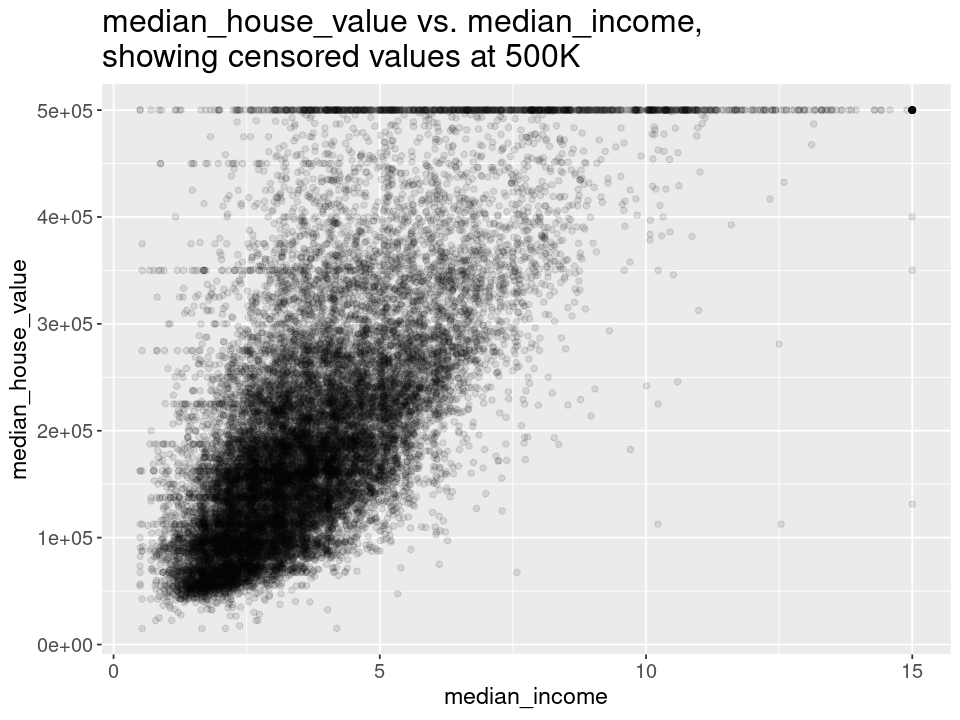

In [7]:
# Plot of median_house_value vs. median_income. 
# 4.8% of the data is censored at 500K.

options(repr.plot.width= 8, repr.plot.height= 6)

p <- ggplot(dat, aes(median_income, median_house_value)) +
  geom_point(alpha= 0.1) + xlab("median_income") + ylab("median_house_value") +
  ggtitle("median_house_value vs. median_income, 
showing censored values at 500K") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
  
p


In [5]:
# There are 990 records, or districts, with a 
# censored median_house_value.

nrow(dat[which(dat$median_house_value >= 500000),])


[1] 990

## Get record counts for 15K interval bins of median_house_value

In order to mimic the age-level counts from Appendix A, we need to discretize median_house_value.  I have chosen 15K rather than 10K for the interval size in order to reduce the variability in the counts.

In [5]:
summary(dat$median_house_val)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  14999  119600  179800  206908  264950  500001 

In [6]:
# Let 15K be the lowest median_house_value in our dataset.

dat[which(dat$median_house_value < 15000), c("median_house_value")] <- 15000


In [48]:
cell_floors <- seq(from= 15000, to= 495000, by= 15000)
length(cell_floors)
names(cell_floors) <- paste(as.character(cell_floors/1000), "K", sep="")
print(cell_floors)


[1] 33

   15K    30K    45K    60K    75K    90K   105K   120K   135K   150K   165K 
 15000  30000  45000  60000  75000  90000 105000 120000 135000 150000 165000 
  180K   195K   210K   225K   240K   255K   270K   285K   300K   315K   330K 
180000 195000 210000 225000 240000 255000 270000 285000 300000 315000 330000 
  345K   360K   375K   390K   405K   420K   435K   450K   465K   480K   495K 
345000 360000 375000 390000 405000 420000 435000 450000 465000 480000 495000 


In [49]:
# Function for obtaining the number of records in each 15K 
# interval.

get_rcd_counts <- function(med_houseVal, varRange, 
                           span=15000, startpt=15000) {  
    
    cell_floors <- seq(from=startpt, to=990000, by=span)
    names(cell_floors) <- paste(as.character(cell_floors/1000), "K", sep="")
    
    cell_floors_tmp <- cell_floors[(as.numeric(cell_floors) >= varRange[1]) &
                                   (as.numeric(cell_floors) <= varRange[2])]
    
    n <- length(cell_floors_tmp) - 1
    counts <- rep(NA, n)
    for(i in 1:n) {
        lower <- as.numeric(cell_floors_tmp[i])
        upper <- as.numeric(cell_floors_tmp[i + 1])
        counts[i] <- length(med_houseVal[((med_houseVal >= lower) &
                                          (med_houseVal < upper))])
    }
    names(counts) <- names(cell_floors_tmp)[1:n]
    return(counts) 
}


In [50]:
observed_counts <- get_rcd_counts(dat$median_house_value, c(15000, 495000))

print(observed_counts)


 15K  30K  45K  60K  75K  90K 105K 120K 135K 150K 165K 180K 195K 210K 225K 240K 
  14   78  587  965 1025 1295 1205 1088 1284 1538 1234 1239  842  931  959  747 
255K 270K 285K 300K 315K 330K 345K 360K 375K 390K 405K 420K 435K 450K 465K 480K 
 656  615  439  355  353  400  386  266  207  190  163  135  115  134   81   68 


In [51]:
# Get the number of records not captured in observed_counts.

nrow(dat) - (sum(observed_counts) + 990)


[1] 19

In [52]:
# The 19 records are between 495K and 500K.

nrow(dat[which((dat$median_house_value >= 495000) & 
               (dat$median_house_value < 500000)),])

excluded_rows <- rownames(dat[which((dat$median_house_value >= 495000) & 
                                    (dat$median_house_value < 500000)),])


[1] 19

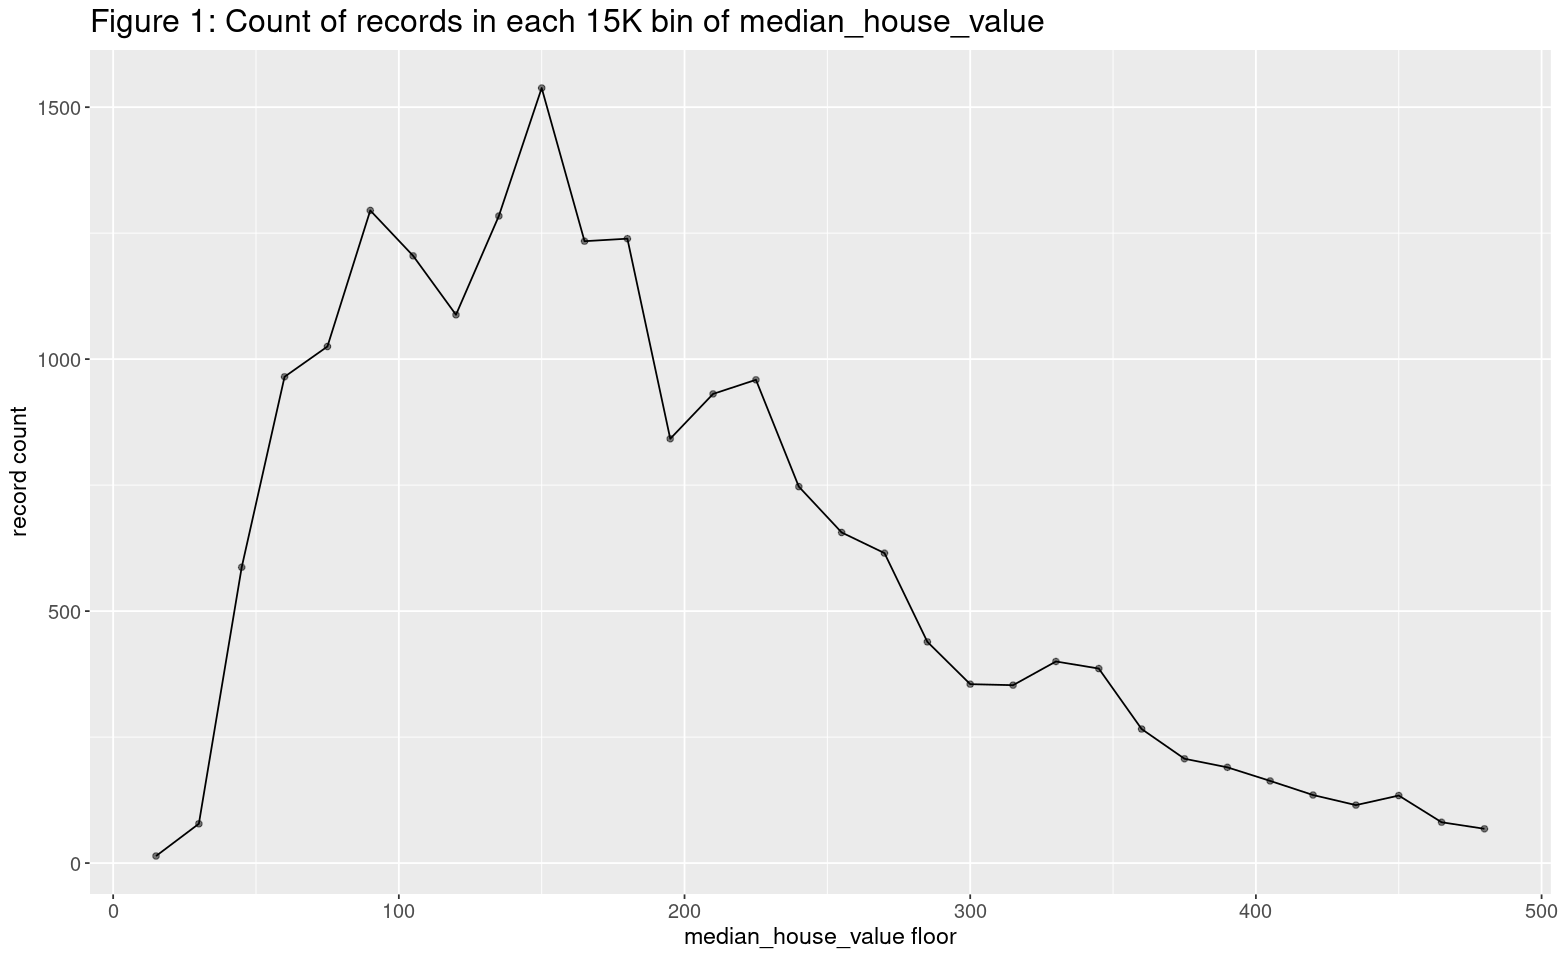

In [53]:
# Plot the counts.  This will give us a very general idea
# of what the distribution of counts might look like for the
# 990 records which need an imputed value.  We are especially
# interested in the general shape of the distribution from
# around 350K onwards.

df_plot <- rep(NA, 2 * length(observed_counts))
dim(df_plot) <- c(length(observed_counts), 2)
df_plot <- as.data.frame(df_plot)
colnames(df_plot) <- c("cell", "count")

new_names <- str_replace_all(names(observed_counts), "[K]", "")
df_plot$cell <- as.numeric(new_names)
df_plot$count <- as.numeric(observed_counts)


options(repr.plot.width= 13, repr.plot.height= 8)

p <- ggplot(df_plot, aes(cell, count)) +
  geom_point(alpha= 0.5) + xlab("median_house_value floor") + 
  ylab("record count") +
  geom_line() +
  ggtitle("Figure 1: Count of records in each 15K bin of median_house_value") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [54]:
# There is much less variability in the tail of the distribution.

dim(df_plot)
print(sd(df_plot$count))
print(sd(df_plot[24:32,]$count))


[1] 32  2

[1] 460.4
[1] 62.905


In [55]:
# Create an example distribution for the expected range of
# imputation.  (Previous work shows an upper limit around
# 840K; so for this example distribution I will go out only
# to the 825K bin.)

bins <- seq(495000, 825000, by= 15000)
bin_names <- paste(as.character(bins/1000), "K", sep="")
names(bins) <- bin_names
names(bins)
length(bins)
# 23

# In addition to the 990 records to distribute, we have 19
# records that belong to the 495K cell.
bin_counts <- c(89, 95, 89, 86, 78, 71, 67, 65, 56, 51, 48, 
                42, 38, 35, 27, 22, 17, 12, 7,  6,  2,  3, 3)
sum(bin_counts)
sum(bin_counts) == (990 + 19)


[1] "495K" "510K" "525K" "540K" "555K" "570K" "585K" "600K" "615K" "630K"
[11] "645K" "660K" "675K" "690K" "705K" "720K" "735K" "750K" "765K" "780K"
[21] "795K" "810K" "825K"

[1] 23

[1] 1009

[1] TRUE

In [56]:
# Construct a dataframe for plotting of the example distribution.

all_names <- c(df_plot$cell[24:32], bin_names)
observed <- df_plot$count[24:32]

all <- c(observed, bin_counts)
n <- length(all)

dftmp <- rep(NA, 2 * n)
dim(dftmp) <- c(n, 2)
dftmp <- as.data.frame(dftmp)
colnames(dftmp) <- c("cell", "count")
dftmp$cell <- all_names
dftmp$count <- all

dftmp$hhval <- as.numeric(str_replace_all(dftmp$cell, "[K]", ""))

head(dftmp); tail(dftmp)


,cell,count,hhval
,<chr>,<dbl>,<dbl>
1,360,266,360
2,375,207,375
3,390,190,390
4,405,163,405
5,420,135,420
6,435,115,435


,cell,count,hhval
,<chr>,<dbl>,<dbl>
27,750K,12,750
28,765K,7,765
29,780K,6,780
30,795K,2,795
31,810K,3,810
32,825K,3,825


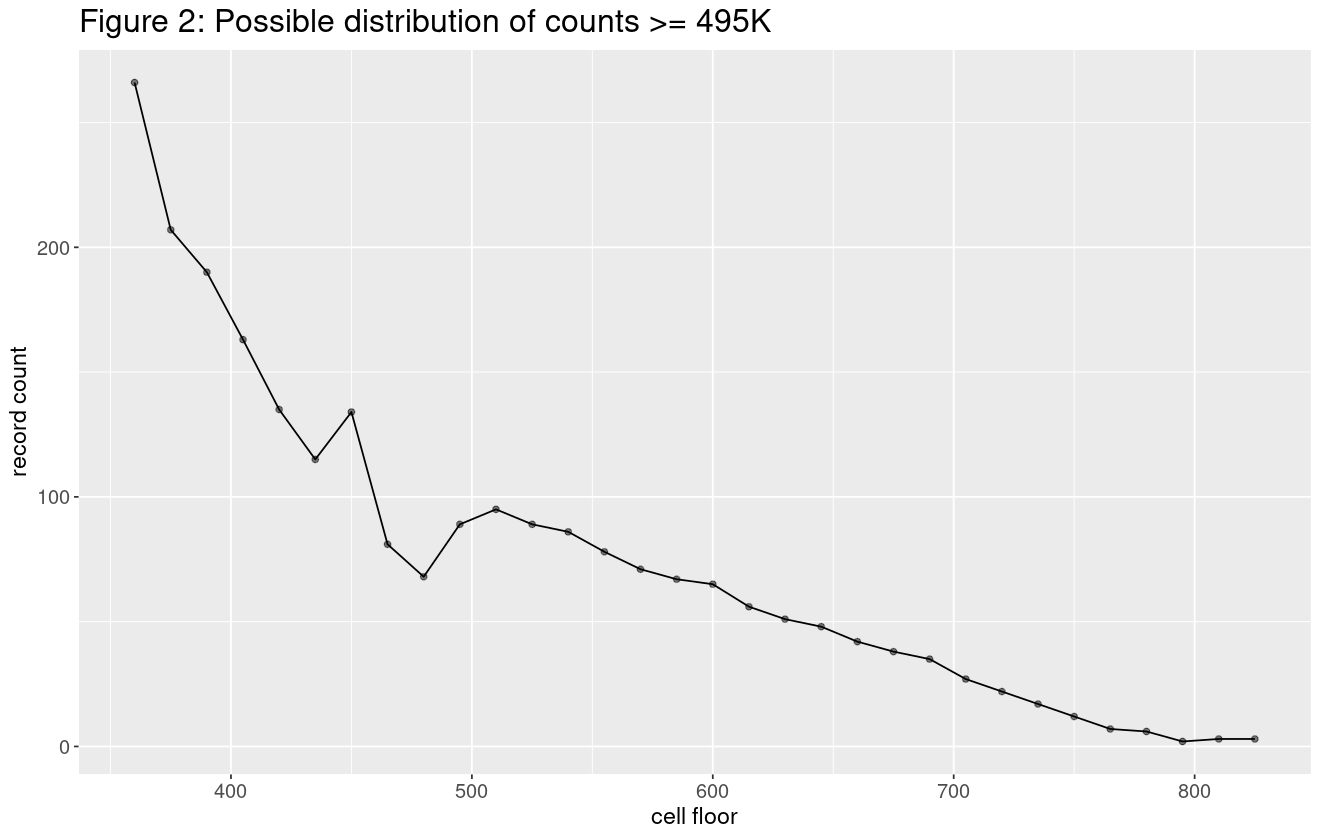

In [57]:
# Plot showing possible distribution of 990 + 19 districts 
# with a median_house_value >= 495K.

options(repr.plot.width= 11, repr.plot.height= 7)

p <- ggplot(dftmp, aes(hhval, count)) +
  geom_point(alpha= 0.5) + xlab("cell floor") + ylab("record count") +
  geom_line() +
  ggtitle("Figure 2: Possible distribution of counts >= 495K") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [58]:
# Compute the mean and median of our example distribution.
# These become our first estimates of the mean and median
# of the actual, unobserved median house values >= 500K.

dftmp <- dftmp[which(dftmp$hhval >= 495),]

# newvals will be used in cells downstream.
newvals <- c()
for(i in 1:nrow(dftmp)) {
    
    # Remove the 19 rcds >= 495K and < 500K.
    ifelse(i > 1, n <- dftmp$count[i], n <- dftmp$count[i] - 19)
    
    ifelse(i > 1, lower <- dftmp$hhval[i], lower <- dftmp$hhval[i] + 5)
    ifelse(i > 1, upper <- lower + 15, upper <- lower + 10)
    
    seed <- set.seed(4321 + i)
    vals <- round(runif(n, lower, upper))
    newvals <- c(newvals, vals)
}

length(newvals)
# 990
round(mean(newvals), 1)
# 599.7
round(median(newvals), 1)
# 586.5


[1] 990

[1] 599.7

[1] 586.5

In [ ]:
### COMMENTS:

# The example distribution has a mean of 600K.
# This is an estimate for the mean of the actual,
# unobserved median house values >= 500K.  The estimate
# for the median is lower, as expected. 


In [59]:
dftmp[1:2,]
dftmp$count[1] <- dftmp$count[1] - 19
sum(dftmp$count)


,cell,count,hhval
,<chr>,<dbl>,<dbl>
10,495K,89,495
11,510K,95,510


[1] 990

In [60]:
# We have 990 imputed values.

imputed_vals_tmp <- 1000*newvals


495K 510K 525K 540K 555K 570K 585K 600K 615K 630K 645K 660K 675K 690K 705K 720K 
  70   95   89   86   78   71   67   65   56   51   48   42   38   35   27   22 
735K 750K 765K 780K 795K 810K 825K 
  17   12    7    6    2    3    3 


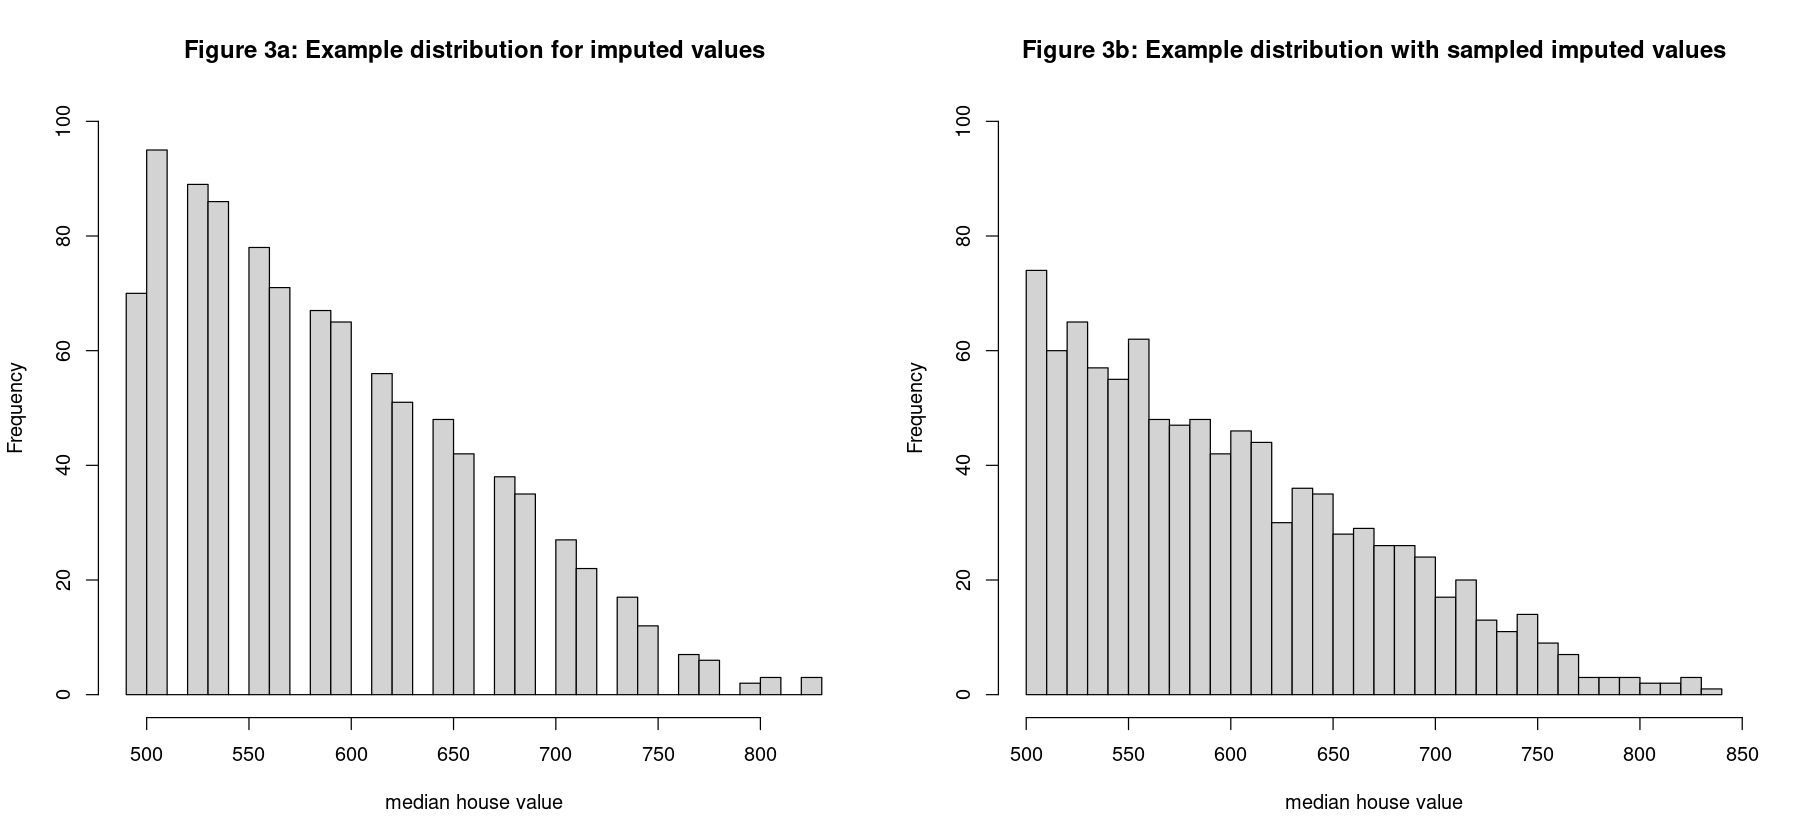

In [27]:
# The histogram below shows the counts for the example
# distribution; this is a close-up of Figure 2.

# bin_counts includes 19 records with a median house value
# between 495K and 500K.
tbl <- bin_counts
tbl[1] <- as.numeric(tbl[1]) - 19
names(tbl) <- bin_names
print(tbl)

options(repr.plot.width= 15, repr.plot.height= 7)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

hist(rep(dftmp$hhval, dftmp$count), breaks=30, xlab="median house value",
     main="Figure 3a: Example distribution for imputed values", ylim=c(0, 100))

hist(newvals, breaks= 30, xlab="median house value", ylim=c(0, 100),
     main="Figure 3b: Example distribution with sampled imputed values")


In [ ]:
### COMMENTS:

# Following Appendix A, I rely on Figures 2 and 3b for 
# judging the plausibility of predicted means and medians
# using the models that follow.


## Compute shift-increment ratios for the mean and median

Use a rolling window of 240K.  This window captures nearly all of the current example distribution of the imputed  values when we start at the cap of 500K.  Compute data from 45K - 330K.  Although this takes us into the region of imputed values (we will use the example distribution of Figure 3b), most of the data for the last few 240K windows will still be observed rather than imputed.  See Appendix A for an example; by doing this, I should be able to obtain more accurate predictions for the mean and median.

In [61]:
bins <- seq(45000, 330000, by= 15000)
bin_names <- paste(as.character(bins/1000), "K", sep="")
names(bins) <- bin_names
length(bins)


[1] 20

In [62]:
# See Figure 3b.
summary(newvals)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    500     539     586     600     649     836 

In [63]:
# Get means and medians for each bin, using a 240K window. 

mean_ratios <- median_ratios <- rep(NA, length(bins))
means <- medians <- rep(NA, length(bins))
rcd_count <- rep(NA, length(bins))

span <- 240000
index <- 0
for(floor in bins) {
    
    index <- index + 1
    ifelse(floor + span < 500000, uprlmt <- floor + span, uprlmt <- 499900)
    hhvals <- as.numeric(dat[which((dat$median_house_value >= floor) &
                        (dat$median_house_value <= uprlmt)),
                  c("median_house_value")])
    hhvals <- c(hhvals, imputed_vals_tmp)
    counts <- as.numeric(get_rcd_counts(hhvals, c(floor, (floor+span))))
    rcd_count[index] <- sum(counts)
    
    # Compute mean.
    hhval_mean <- round(mean(hhvals), 5)
    mean_ratios[index] <- round(hhval_mean/floor, 3)
    means[index] <- hhval_mean

    # Compute median.
    hhval_median <- round(median(hhvals), 5)
    median_ratios[index] <- round(hhval_median/floor, 3)
    medians[index] <- hhval_median
}

paste0("These are the 240K shift increments for the means: ")
names(mean_ratios) <- bin_names
print(mean_ratios)


[1] "These are the 240K shift increments for the means: "

  45K   60K   75K   90K  105K  120K  135K  150K  165K  180K  195K  210K  225K 
4.093 3.193 2.682 2.351 2.142 1.983 1.851 1.755 1.701 1.648 1.612 1.565 1.534 
 240K  255K  270K  285K  300K  315K  330K 
1.517 1.496 1.473 1.456 1.430 1.401 1.378 


In [64]:
# Construct dataframe for plotting, etc.

df_ratios <- rep(NA, 6*length(mean_ratios))
dim(df_ratios) <- c(length(mean_ratios), 6)
df_ratios <- as.data.frame(df_ratios)
colnames(df_ratios) <- c("cell", "rcds","mean","median","mean_ratio","median_ratio")
df_ratios$cell <- bins
df_ratios$rcds <- rcd_count
df_ratios$mean_ratio <- mean_ratios
df_ratios$median_ratio <- median_ratios
df_ratios$mean <- means
df_ratios$median <- medians


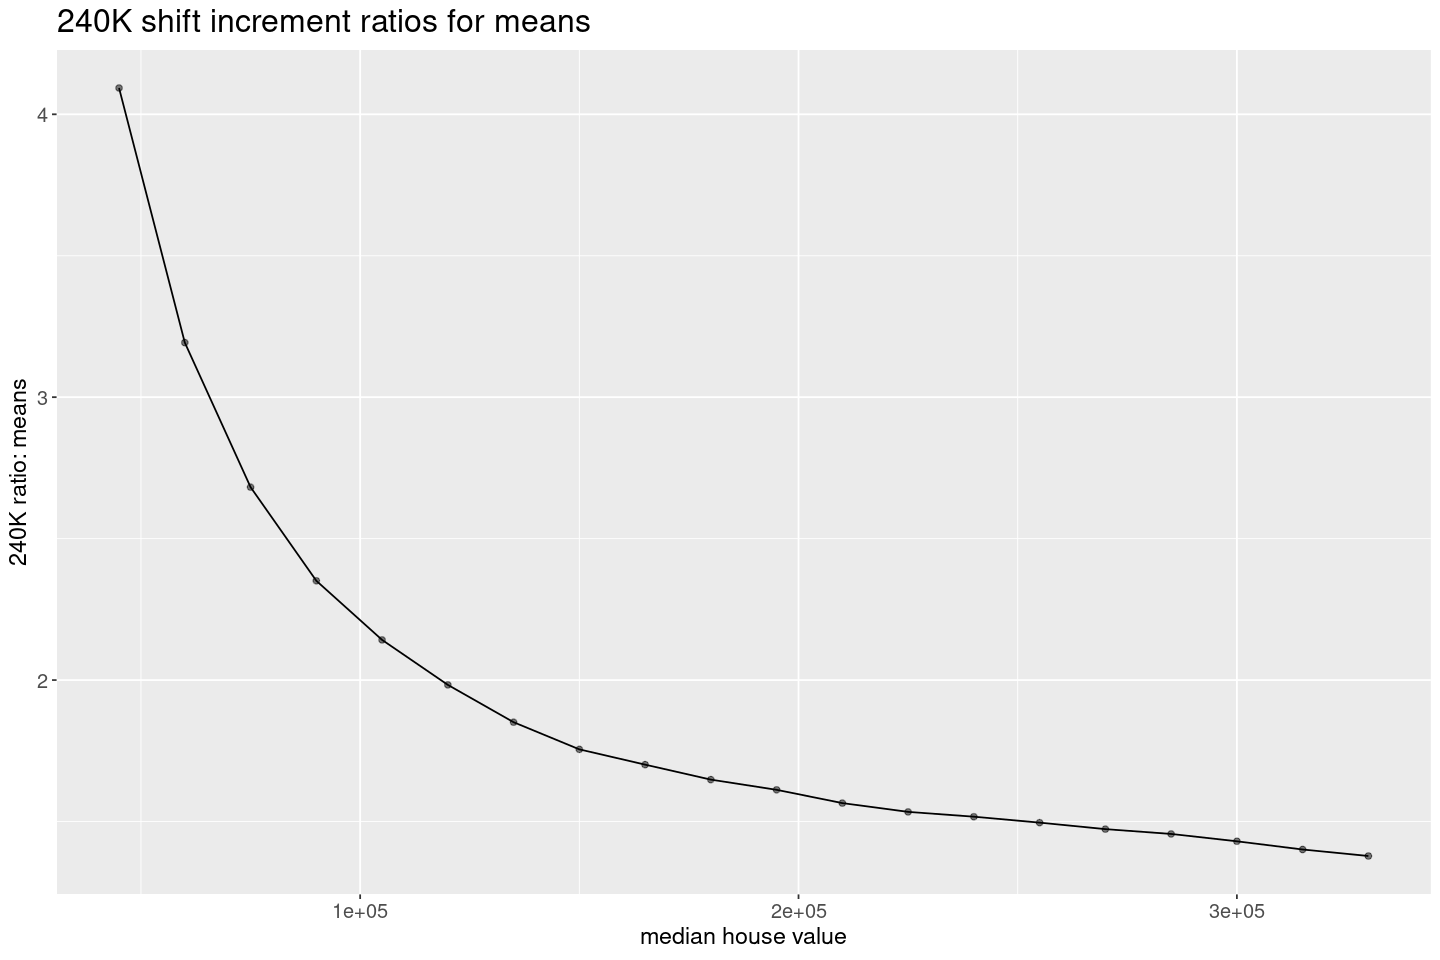

In [65]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_ratios, aes(cell, mean_ratio)) +
  geom_point(alpha= 0.5) + xlab("median house value") + 
  ylab("240K ratio: means") +
  geom_line() +
  ggtitle("240K shift increment ratios for means") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [66]:
df_ratios$rcds


[1] 16210 16062 15452 14780 13885 13066 12244 11167  9819  8748  7644  6917
[13]  6120  5242  4563  3992  3473  3123  2856  2579

In [67]:
# Model for predicting mean_ratio at 500K.

g02 <- lm(I(mean_ratio^0.14) ~ I(rcds^0.2) + I((rcds^0.2)^2) + 
          I(cell^-0.5) + I((cell^-0.5)^2), 
          data= df_ratios)

ans <- summary(g02)
ans[[1]] <- ""; ans



Call:
""

Residuals:
      Min        1Q    Median        3Q       Max 
-5.01e-04 -3.29e-04 -6.40e-06  2.67e-04  8.46e-04 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)
(Intercept)       8.45e-01   1.79e-02   47.19  < 2e-16
I(rcds^0.2)       3.32e-02   5.21e-03    6.37  1.3e-05
I((rcds^0.2)^2)  -4.55e-03   5.39e-04   -8.43  4.5e-07
I(cell^-0.5)      8.92e+01   5.01e+00   17.81  1.7e-11
I((cell^-0.5)^2) -2.61e+03   6.22e+02   -4.20  0.00077

Residual standard error: 0.000424 on 15 degrees of freedom
Multiple R-squared:     1,	Adjusted R-squared:     1 
F-statistic: 5.74e+04 on 4 and 15 DF,  p-value: <2e-16


In [68]:
ncvTest(g02)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.086721, Df = 1, p = 0.768

In [69]:
residualPlots(g02, plot=FALSE)


                 Test stat Pr(>|Test stat|)
I(rcds^0.2)           0.83            0.418
I((rcds^0.2)^2)       1.93            0.074
I(cell^-0.5)         -1.42            0.178
I((cell^-0.5)^2)      2.72            0.017
Tukey test            0.12            0.901


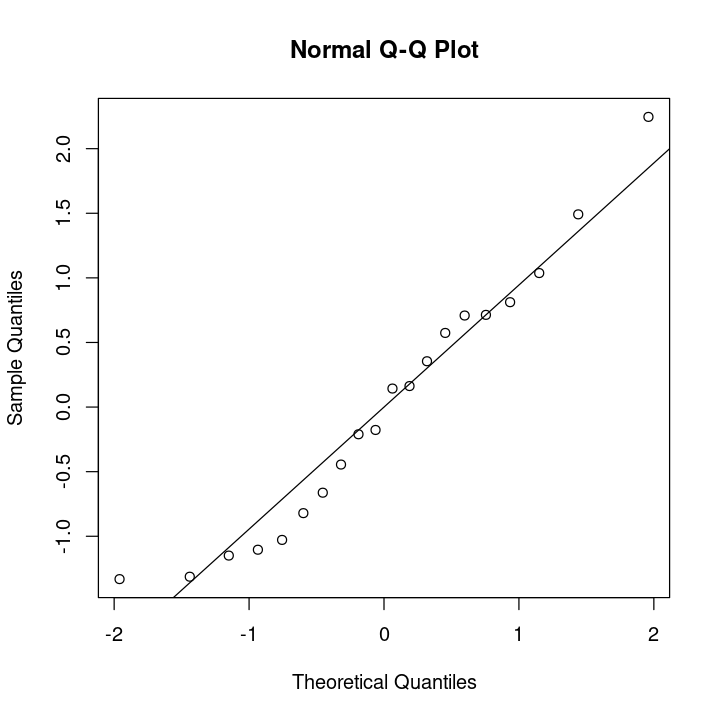

In [70]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(g02, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [71]:
# Prediction for mean for [500K, 740K].

newdat <- df_ratios[1, ]
newdat[1, ] <- c(500000, 990, rep(NA, 4))

ans <- predict.lm(g02, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.14); ans_transf
# 1.198

# 1.198 * 500K = 599K.


1 
1.1983

In [72]:
# Compute a 95% CI for this prediction.

round((ans + c(-2,2)*0.000424)^(1/0.14) * 500)
# [596, 603]


[1] 596 603

In [ ]:
### COMMENTS:

# The 599K number is very plausible, especially given that
# it is exactly what we got with the example distribution.
# I would expect a few districts to have a median_house_value
# > 740K.  The distribution in Figure 3a has slightly more 
# than 3% of the records with a median house value > 740K.  
# So perhaps we should estimate the mean at 605K.


### Get a prediction for the median

In [73]:
paste0("These are the 240K shift increments for the medians: ")
names(median_ratios) <- bin_names
print(median_ratios)


[1] "These are the 240K shift increments for the medians: "

  45K   60K   75K   90K  105K  120K  135K  150K  165K  180K  195K  210K  225K 
3.596 2.772 2.324 2.034 1.835 1.719 1.614 1.524 1.475 1.437 1.405 1.366 1.357 
 240K  255K  270K  285K  300K  315K  330K 
1.365 1.345 1.316 1.304 1.289 1.270 1.263 


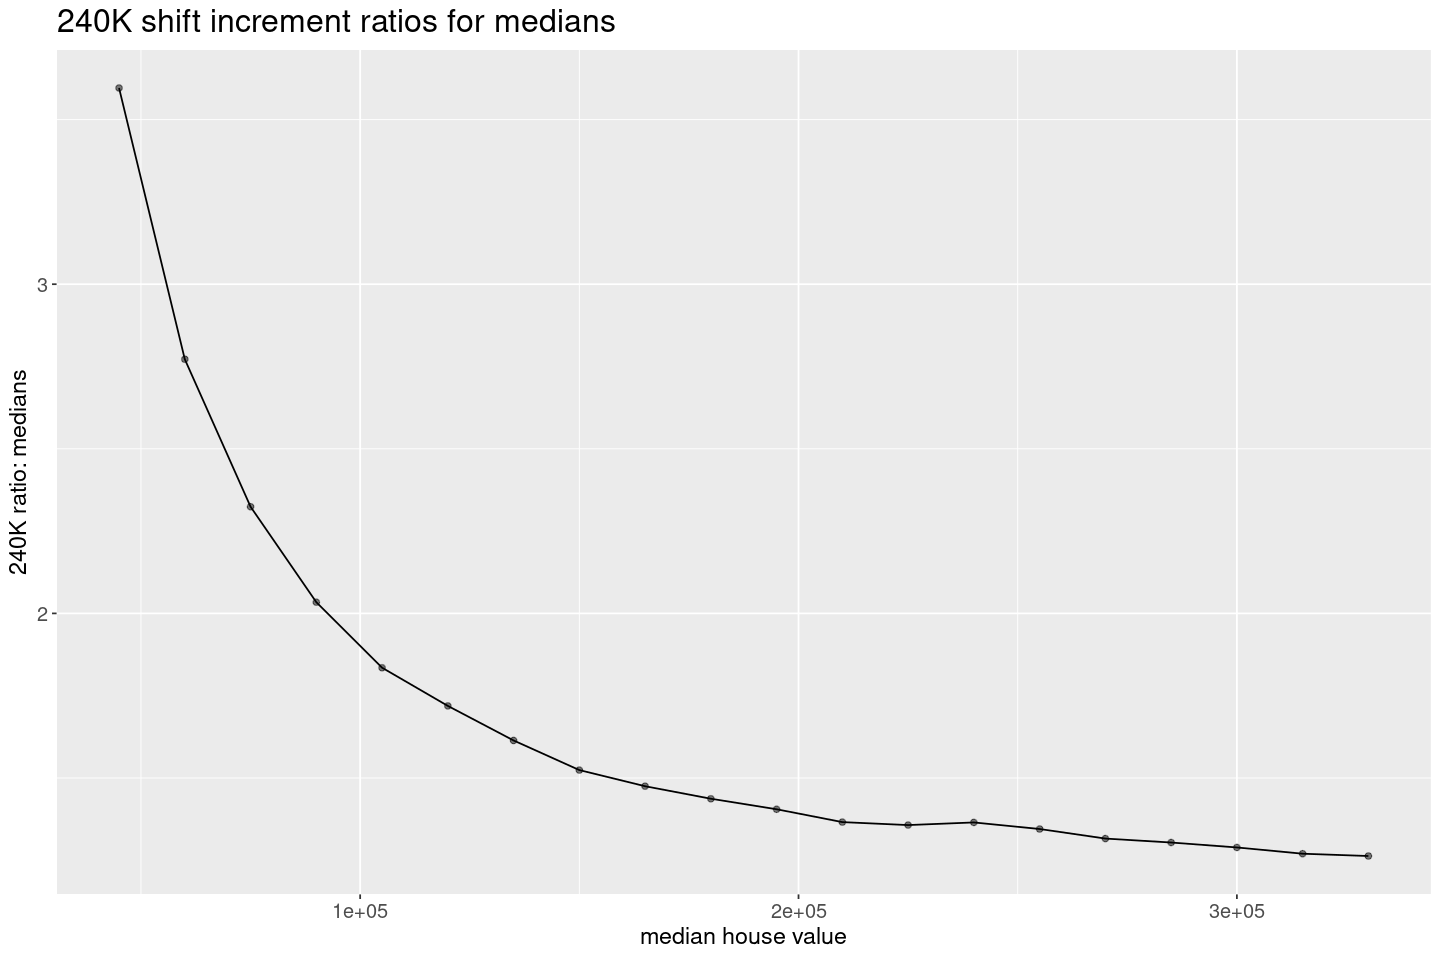

In [74]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_ratios, aes(cell, median_ratio)) +
  geom_point(alpha= 0.5) + xlab("median house value") + 
  ylab("240K ratio: medians") +
  geom_line() +
  ggtitle("240K shift increment ratios for medians") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [75]:
# Model for predicting median_ratio at 500K.

g03 <- lm(I(median_ratio^0.34) ~ I(rcds^0.285) + I((rcds^0.285)^2) + 
          I(cell^-0.54), 
          data= df_ratios)

ans <- summary(g03)
ans[[1]] <- ""; ans



Call:
""

Residuals:
      Min        1Q    Median        3Q       Max 
-0.004056 -0.001282 -0.000781  0.000780  0.005058 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)
(Intercept)        8.10e-01   3.50e-02   23.17  9.8e-14
I(rcds^0.285)      6.14e-03   5.59e-03    1.10  0.28777
I((rcds^0.285)^2) -1.05e-03   2.39e-04   -4.38  0.00046
I(cell^-0.54)      2.93e+02   3.24e+00   90.45  < 2e-16

Residual standard error: 0.00257 on 16 degrees of freedom
Multiple R-squared:     1,	Adjusted R-squared:     1 
F-statistic: 1.47e+04 on 3 and 16 DF,  p-value: <2e-16


In [76]:
ncvTest(g03)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.60435, Df = 1, p = 0.437

In [77]:
residualPlots(g03, plot=FALSE)


                  Test stat Pr(>|Test stat|)
I(rcds^0.285)         -0.22             0.83
I((rcds^0.285)^2)      0.33             0.75
I(cell^-0.54)          0.82             0.43
Tukey test             0.82             0.41


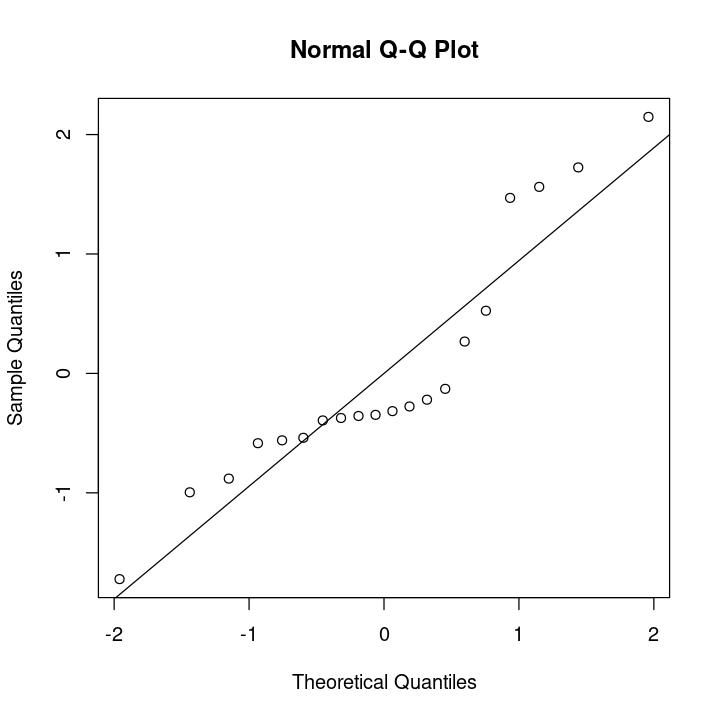

In [78]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(g03, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))

# This plot does not inspire much confidence.


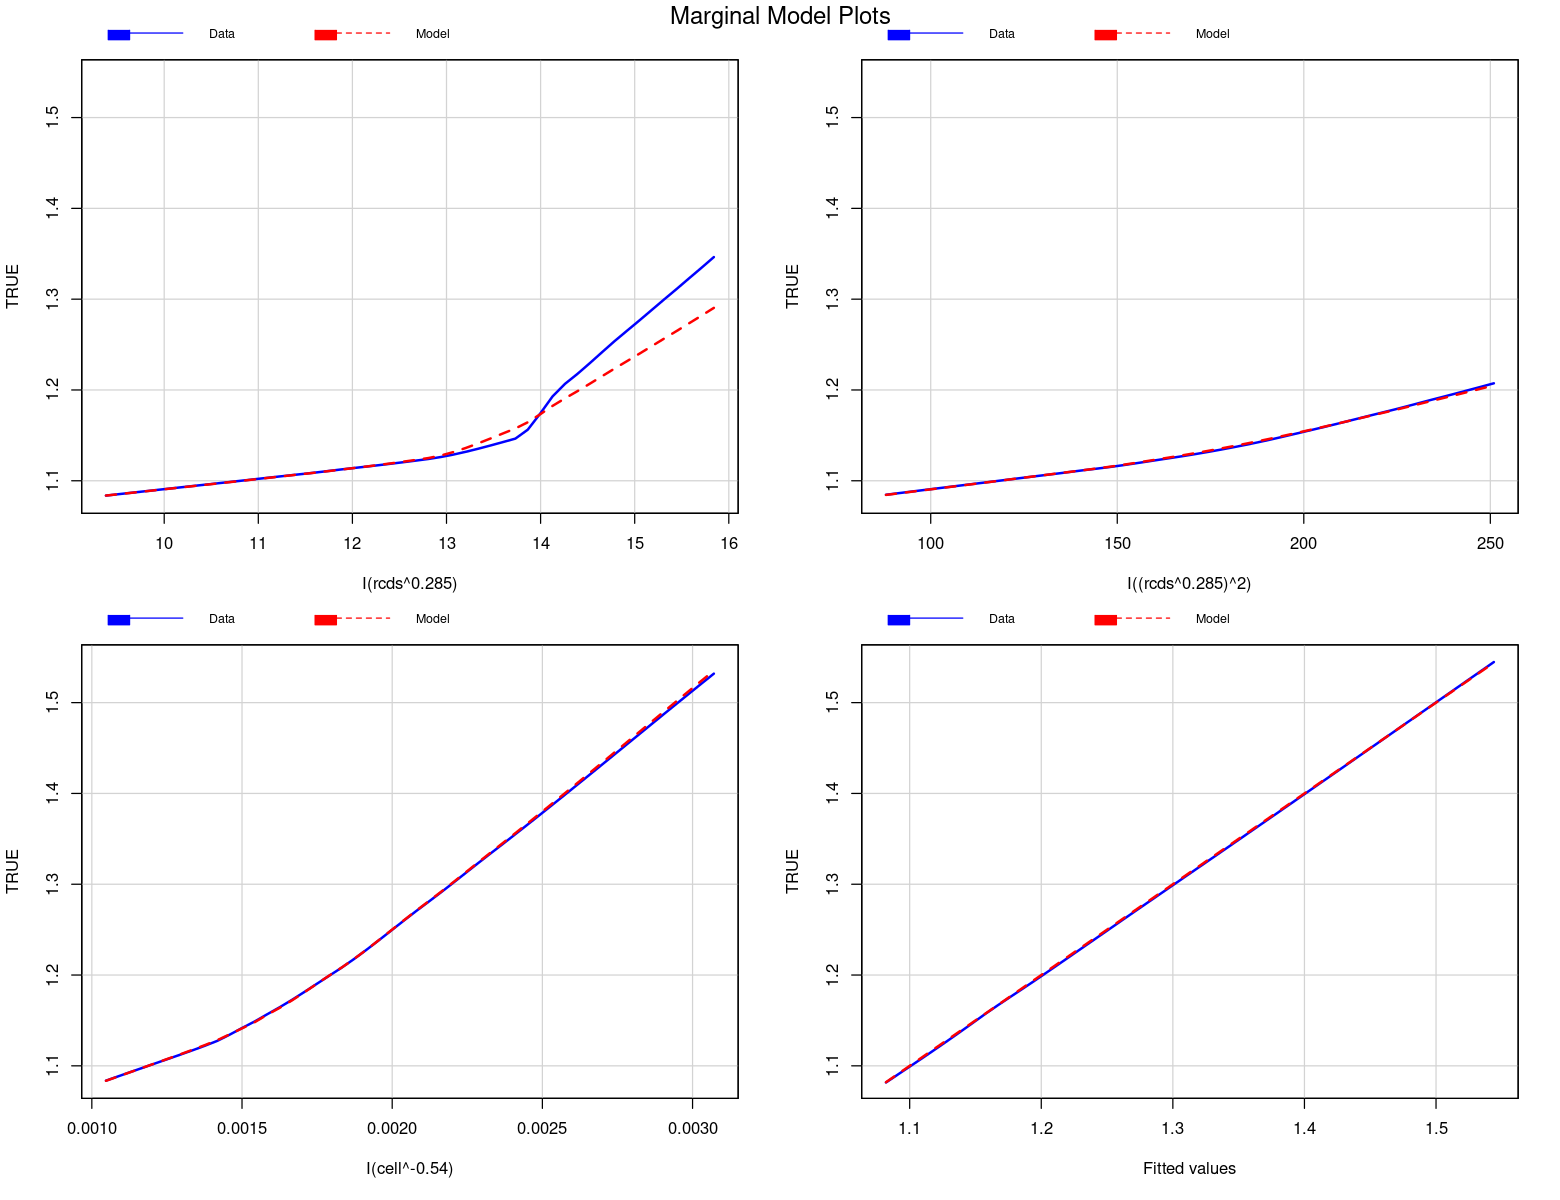

In [45]:
options(repr.plot.width= 13, repr.plot.height= 10)

# blue= data; red= model
mmps(g03, ~., pch=NA)


In [79]:
# Prediction for median for [500K, 740K].

newdat <- df_ratios[1, ]
newdat[1, ] <- c(500000, 990, rep(NA, 4))

ans <- predict.lm(g03, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.34); ans_transf
# 1.139

# 1.139 * 500K = 570K.


1 
1.1393

In [80]:
# Compute a 95% CI for this prediction.

round((ans + c(-2,2)*0.00257)^(1/0.34) * 500)
# [561, 578]


[1] 561 578

In [ ]:
### COMMENTS:

# The prediction of 570K seems low.  The prediction from
# the example distribution shown in Figure 3b is 586K.
# But the example distribution is constructed from a 
# uniform distribution in each 15K cell, and we do not
# expect such a distribution in each cell.  We expect
# the counts, on average, to decrease as we move right.

# At this juncture, I would expect a median somewhere 
# in the range of 575K-590K.  This range is plausible
# given our expected mean of 605K.


## Final Comments for Section 1

As noted in Appendix A, for the imputation process that follows, getting good predictions for the median and mean is crucial.  From the above we can be fairly confident that the mean for the median house values >= 500K is close to **605K**.  We can be fairly confident that the median will be less than the mean.  The median is likely to be between **575K** and **590K**, assuming the mean is in fact around 605K.

As in Appendix A, it is much harder to predict for the median than it is for the mean.

A virtue of both g02 and g03 is that the record counts in each cell are accounted for.



# Section 2: impute values for censored median house values

In [221]:
# The following model is what we will use to predict the
# median house values that we need.

m01 <- lm(I(median_house_value^0.18) ~ 
          
           I(median_income^0.77) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
          data= dat)

m01.summary <- summary(m01)
m01.summary[[1]] <- ""; round(m01.summary$adj.r.squared, 3)


[1] 0.73

In [222]:
ncvTest(m01)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.00043524, Df = 1, p = 0.983

In [223]:
residualPlots(m01, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(median_income^0.77)         -14.13           <2e-16
I(long_transf^-0.5)             1.99            0.046
I(long_transf^-1)              11.11           <2e-16
I(long_transf^-1.5)            11.55           <2e-16
latitude                        0.89            0.373
I(latitude^2)                  -0.40            0.692
I(latitude^3)                  33.30           <2e-16
I(latitude^4)                  33.28           <2e-16
pop_per_hh                     -1.32            0.186
I(pop_per_hh^2)               -13.36           <2e-16
I(housing_median_age^0.15)      0.46            0.645
HHdens_ln                      11.34           <2e-16
Tukey test                      0.07            0.944


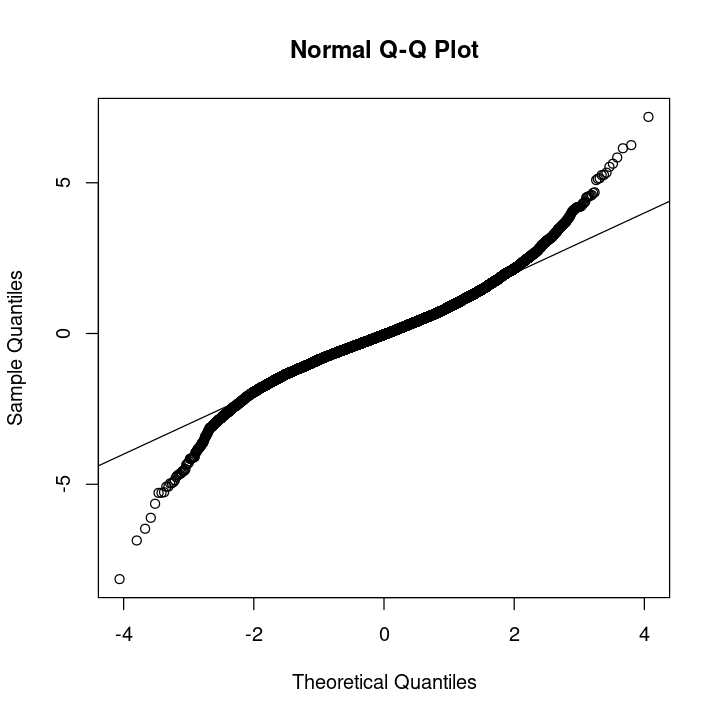

In [224]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(m01, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [225]:
# Get a sense of the uncertainty for the model's sigma.
# (sim is from the arm package.)

m01.sim <- sim(m01, n.sims=3000)


In [226]:
sigma.m01.sim <- sigma.hat(m01.sim)
str(sigma.m01.sim)


 num [1:3000] 0.472 0.465 0.47 0.469 0.468 ...


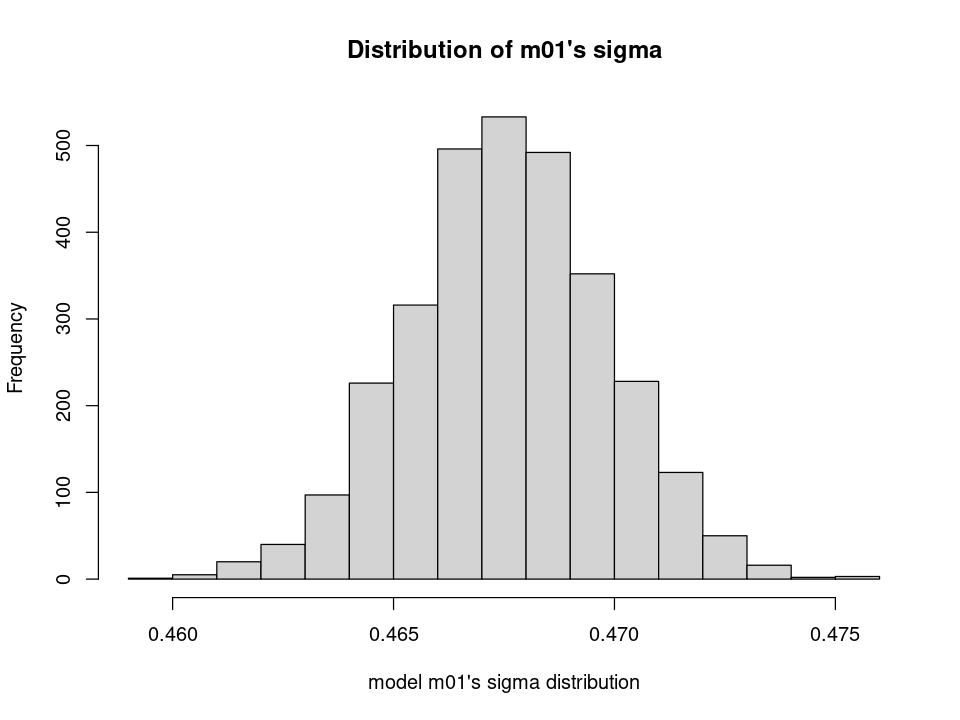

In [227]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(sigma.m01.sim, breaks=20, main="Distribution of m01's sigma",
     xlab="model m01's sigma distribution")


In [ ]:
# sigma.hat is small because of the power transformation
# on the response variable.


### Gibbs sampler for imputing censored median_house_values

In [82]:
# Because of the transformation on the response variable,
# we need to transform our limits.  Here I am setting the 
# upper limit to 840K. 

cap <- 500000
response_var_power <- 0.18
inv_pwr <- 1/response_var_power

C <- cap^response_var_power
C_upper <- (1.68*cap)^response_var_power

censored <- (dat$median_house_value)^response_var_power >= C

# Create some crude starting values.
n.censored <- sum(censored)
z <- ifelse(censored, NA, (dat$median_house_value)^response_var_power)
z[censored] <- runif(n.censored, C, C_upper)


In [83]:
length(censored)
n.censored


[1] 20603

[1] 990

In [318]:
summary(z[censored])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   10.6    10.9    11.1    11.1    11.4    11.7 

In [319]:
# Identify the rows that are censored.

rows_censored <- rownames(dat)[censored]
head(rows_censored)


[1] "90"  "460" "494" "495" "510" "511"

In [81]:
# Function to draw from a constrained normal distribution.

rnorm.trunc03 <- function(n, mu, sigma, lo=-Inf, hi=Inf) {
    
    # We need each mu to be >= C.  Otherwise the return 
    # value will be Inf.
    cap <- 500000
    mu02 <- ifelse(mu <= C, (cap + 100)^response_var_power, mu)
    
    p.lo <- pnorm(lo, mu02, sigma)
    p.hi <- pnorm(hi, mu02, sigma)
    u <- runif(n, p.lo, p.hi)
    return(qnorm(u, mu02, sigma))
}


In [84]:
# Create matrix X for the terms in our model.

X <- dat

X$median_income <- (X$median_income)^0.77

X$lat2 <- (X$latitude)^2
X$lat3 <- (X$latitude)^3
X$lat4 <- (X$latitude)^4

X$long_1 <- (X$long_transf)^-0.5
X$long_2 <- (X$long_transf)^-1
X$long_3 <- (X$long_transf)^-1.5

X$pphh1 <-  X$pop_per_hh
X$pphh2 <- (X$pop_per_hh)^2

X$housing_median_age <- (X$housing_median_age)^0.15

X$HHdens_by_long <- X$HHdens_ln * X$long_transf
X$HHdens_by_income <- X$HHdens_ln * X$median_income
X$HHdens_3way <- X$HHdens_ln * X$median_income * X$housing_median_age



X <- X[, c("median_income","long_1","long_2","long_3","latitude","lat2",
           "lat3","lat4","pphh1","pphh2", "housing_median_age",
           "HHdens_ln", "HHdens_by_long","HHdens_by_income",
           "HHdens_3way")]
intercept <- rep(1, nrow(dat))

init.colnames <- colnames(X)

X <- as.data.frame(cbind(intercept, X), col.names=c("intercept", init.colnames),
                   row.names=rownames(dat))
dim(X)
colnames(X)


[1] 20603    16

[1] "intercept"          "median_income"      "long_1"            
 [4] "long_2"             "long_3"             "latitude"          
 [7] "lat2"               "lat3"               "lat4"              
[10] "pphh1"              "pphh2"              "housing_median_age"
[13] "HHdens_ln"          "HHdens_by_long"     "HHdens_by_income"  
[16] "HHdens_3way"

In [322]:
# See p.406 (Section 18.5) of Gelman and Hill's book,
# "Data Analysis Using Regression and Multilevel/Hierarchical
# Models".

# Fit a regression using the crude starting values of z.

m01_tst <- lm(z ~ 
              
           I(median_income^0.77) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= dat)    

# Obtain a sample draw of the model coefficients and of
# parameter sigma.
sim.1 <- sim(m01_tst, n.sims=1)


In [323]:
beta <- coef(sim.1)
dim(beta)
colnames(beta)


[1]  1 16

[1] "(Intercept)"                               
 [2] "I(median_income^0.77)"                     
 [3] "I(long_transf^-0.5)"                       
 [4] "I(long_transf^-1)"                         
 [5] "I(long_transf^-1.5)"                       
 [6] "latitude"                                  
 [7] "I(latitude^2)"                             
 [8] "I(latitude^3)"                             
 [9] "I(latitude^4)"                             
[10] "pop_per_hh"                                
[11] "I(pop_per_hh^2)"                           
[12] "I(housing_median_age^0.15)"                
[13] "HHdens_ln"                                 
[14] "HHdens_ln:long_transf"                     
[15] "HHdens_ln:median_income"                   
[16] "HHdens_ln:median_income:housing_median_age"

In [324]:
# Here are means for 6 different normal
# distributions.

means <- as.matrix(X) %*% t(beta)
length(means)
round(head(as.vector(means)^inv_pwr))


[1] 20603

[1] 463919 511457 366642 295769 228446 239048

In [325]:
# All values should be between 500K and 840K
z.old <- z[censored]
round(head(z.old)^inv_pwr)


[1] 749192 797253 546781 743938 727648 788002

In [326]:
# All values should be between 500K and 840K.
sigma <- sigma.hat(sim.1)
round(sigma, 4)

z.new <- rnorm.trunc03(n.censored, means[censored], sigma, lo=C, hi=C_upper)
round(head(as.vector(z.new)^inv_pwr))


[1] 0.5007

[1] 646858 560676 652680 557431 699654 572599

In [327]:
summary(z.new^inv_pwr)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 500427  552221  616704  633886  709636  839529 

In [284]:
# For the Gibbs sampler, the above is now put into
# a loop.  We first test with 100 iterations.

n <- nrow(dat)
n.chains <- 4
n.iter <- 2000

sims <- array(NA, c(n.iter, n.chains, 17 + n.censored))
dimnames(sims) <- list(NULL, NULL, c(colnames(X), "sigma", 
                                     paste("z[", (1:n)[censored],
                                           "]", sep="")))

start <- Sys.time()
for(m in 1:n.chains) {
    
    # acquire some initial values
    z[censored] <- runif(n.censored, C, C_upper)
    
    for(t in 1:n.iter) {
        
        m01.1 <- lm(z ~ 
                    
           I(median_income^0.77) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= dat)   
        
        sim.1 <- sim(m01.1, n.sims=1)
        beta <- coef(sim.1)
        sigma <- sigma.hat(sim.1)
        means <- as.matrix(X) %*% t(beta)
        z[censored] <- rnorm.trunc03(n.censored, means[censored], sigma, lo=C, hi=C_upper)
        stopifnot(sum(z[censored] < Inf) == n.censored)
        sims[t,m,] <- c(beta, sigma, z[censored])
    }
}

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 4.14 minutes.


Time difference of 4.49 mins

In [242]:
# Check for convergence.

# sims.bugs <- R2OpenBUGS::as.bugs.array(sims, n.burnin=1000)
# print(sims.bugs)

# The Rhat value for every parameter and every imputed
# value should be 1.0.


In [285]:
save(sims, file="/home/greg/Documents/stat/Geron_ML/datasets/housing/sims_raw_hhvals.RData")


In [85]:
load("/home/greg/Documents/stat/Geron_ML/datasets/housing/sims_raw_hhvals.RData")


In [86]:
# Drop the first 1000 iterations.

sims_adj <- sims[1001:2000, ,]
dim(sims_adj)


[1] 1000    4 1007

In [87]:
sims_adj.bugs <- R2OpenBUGS::as.bugs.array(sims_adj)
# print(sims_adj.bugs)


In [88]:
# Extract the means and stddevs for each of the censored records.

z_means <- sims_adj.bugs$mean$z
z_sds <- sims_adj.bugs$sd$z
round(head(z_means), 2); round(head(z_sds), 2)


[1] 10.98 10.98 10.97 10.99 10.98 11.21

[1] 0.26 0.25 0.25 0.25 0.26 0.27

In [89]:
summary(z_means)
summary(z_sds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   11.0    11.0    11.0    11.1    11.1    11.5 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.111   0.252   0.255   0.255   0.263   0.282 

In [92]:
summary(round(z_means^inv_pwr))


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 598435  601765  603464  629282  644081  795604 

In [93]:
# Average estimate of the sd.

(sd_estimate <- round((11 + 0.255)^inv_pwr) - round(11^inv_pwr))
# 82,860


[1] 82860

In [94]:
# Here is a fuller summary for the stddevs.

ans <- round((z_means + z_sds)^inv_pwr) - round(z_means^inv_pwr)
summary(ans)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  43274   81078   82080   84610   89169   98936 

In [ ]:
### COMMENTS:

# Based on the work above, we expect the mean to be about
# 605K if the upper limit is around 840K.  The mean is
# currently around 640K (see next summary).


In [95]:
# Get some predictions, using rnorm.trunc03.

set.seed(1931)
z_preds <- round(rnorm.trunc03(n.censored, z_means, z_sds, lo=C, hi=C_upper), 5)
z_preds <- round(z_preds^inv_pwr)
summary(z_preds)

# Notice that the mean is at 640K.  We do not expect the mean 
# to be this high because model g02 is a fairly good model 
# and it predicts a mean much closer to 605K.  Also, the 
# example distribution of Figure 3b has a mean at 599K.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 500761  578612  632510  639827  693094  839880 

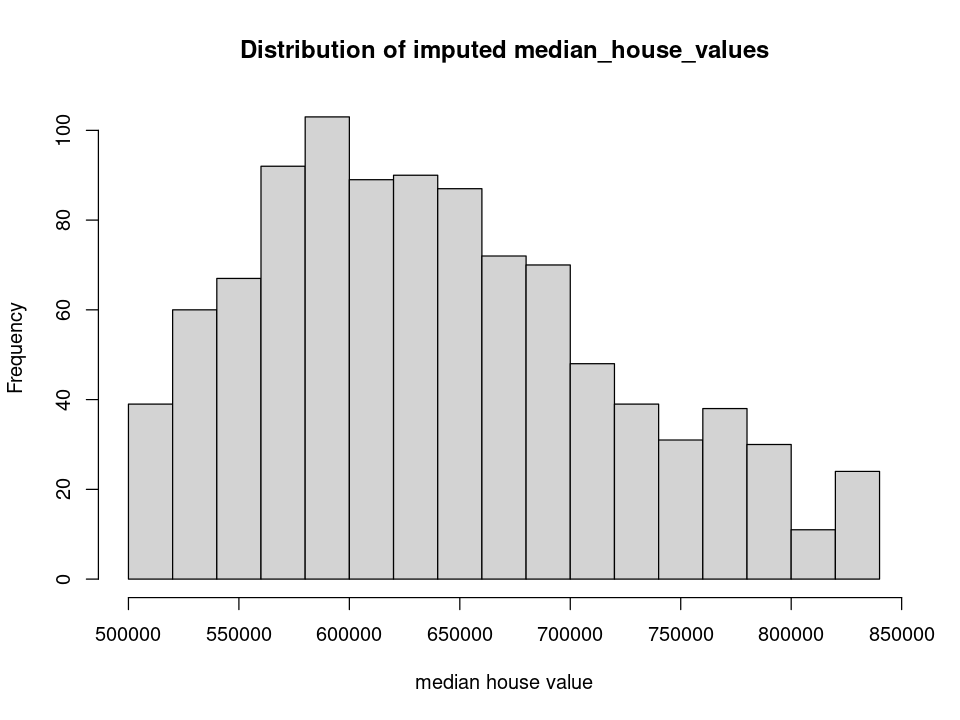

In [69]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds, breaks=20, main="Distribution of imputed median_house_values",
     xlab="median house value")


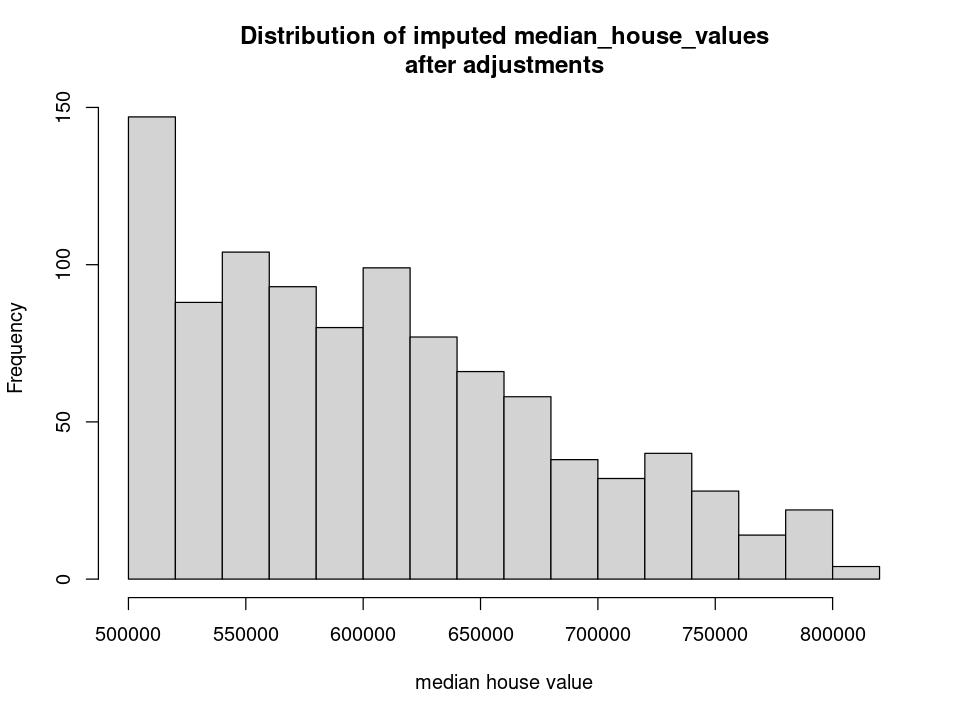

In [96]:
# Adjust the predictions so that the mean is closer to
# 605K.

z_preds_adj <- z_preds - 36000
preds_adj <- ifelse(z_preds_adj < 500000, 500000, z_preds_adj)

options(repr.plot.width= 8, repr.plot.height= 6)

hist(preds_adj, breaks=14, main="Distribution of imputed median_house_values
after adjustments",
     xlab="median house value")


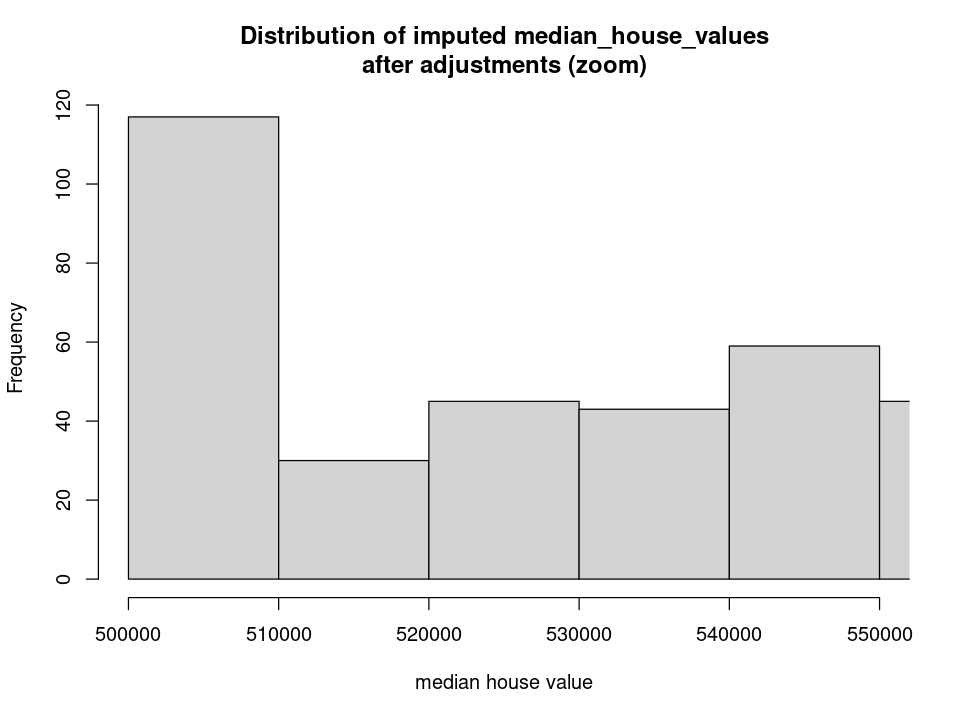

In [97]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(preds_adj, breaks=40, 
     main="Distribution of imputed median_house_values
after adjustments (zoom)", xlim= c(500000, 550000),
     xlab="median house value")


In [98]:
# The mean is now about where we expect it to be.

summary(preds_adj)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 500000  542612  596510  605210  657094  803880 

In [ ]:
### COMMENTS:

# We need to correct for the sharp drop in counts, since
# this is not what we expect for the shape of our 
# distribution.  As in  Appendix A, we can try to correct
# this by adjusting the z_means before calling rnorm.trunc03.
# We want to shift the z_means over by the same amount.  
# rnorm.trunc03 can then correct the means that are below C.


In [99]:
(z_means_bar <- mean(z_means))

z_means_adj <- z_means - (z_means_bar - 605000^response_var_power)
summary(z_means_adj)
round(mean(z_means_adj)^inv_pwr)


[1] 11.057

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   10.9    10.9    10.9    11.0    11.0    11.5 

[1] 605000

In [100]:
# Get new predictions.

set.seed(1931)
z_preds <- round(rnorm.trunc03(n.censored, z_means_adj, z_sds, lo=C, hi=C_upper), 5)
z_preds <- round(z_preds^inv_pwr)
summary(z_preds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 500496  563277  613751  623219  671848  839804 

In [101]:
# Make another correction.  Also adjust C_upper.

C_upper <- 11.48

z_means_adj <- z_means - (z_means_bar - 587000^response_var_power)

set.seed(1933)
z_preds <- round(rnorm.trunc03(n.censored, z_means_adj, z_sds, lo=C, hi=C_upper), 5)
z_preds <- round(z_preds^inv_pwr)
summary(z_preds)
# The mean is now at 605K.  And the median is at 593K.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 500779  552840  593450  605091  651704  773490 

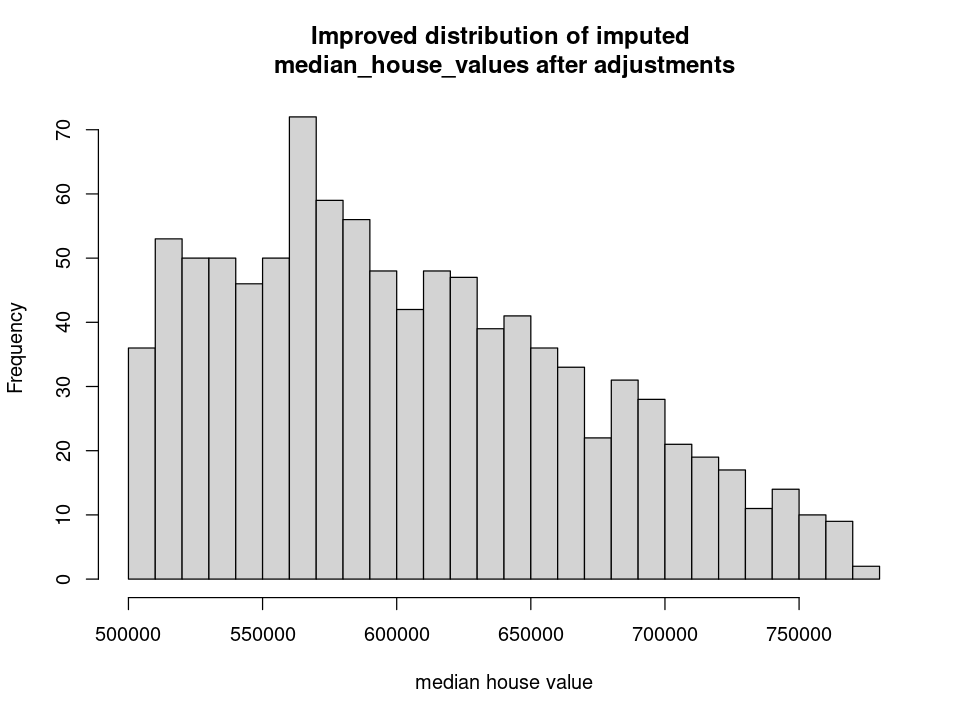

In [102]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds, breaks=20, main="Improved distribution of imputed 
median_house_values after adjustments",
     xlab="median house value")


In [ ]:
### COMMENTS:

# The predictions for median_house_value are, for some
# reason, more difficult to manipulate than those for
# housing_median_age in Appendix A.  In order to bring
# the mean and median closer to where we expect them to
# be, I had to restrict the upper limit quite a bit.  The
# maximum prediction we now have is just under 775K.

# With the current imputed values, we can now construct
# new models and see if a new set of predictions for the
# mean and median for the 500K cell are consistent with the
# current set of imputed values.  If we have consistency,
# then we can stick with these imputed values.  Otherwise,
# we will have to generate a new set of imputed values.


In [103]:
# Assign imputed values.

newdat <- dat
newdat$median_house_value[censored] <- z_preds
summary(newdat$median_house_value)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15000  119600  179800  211958  264950  773490 

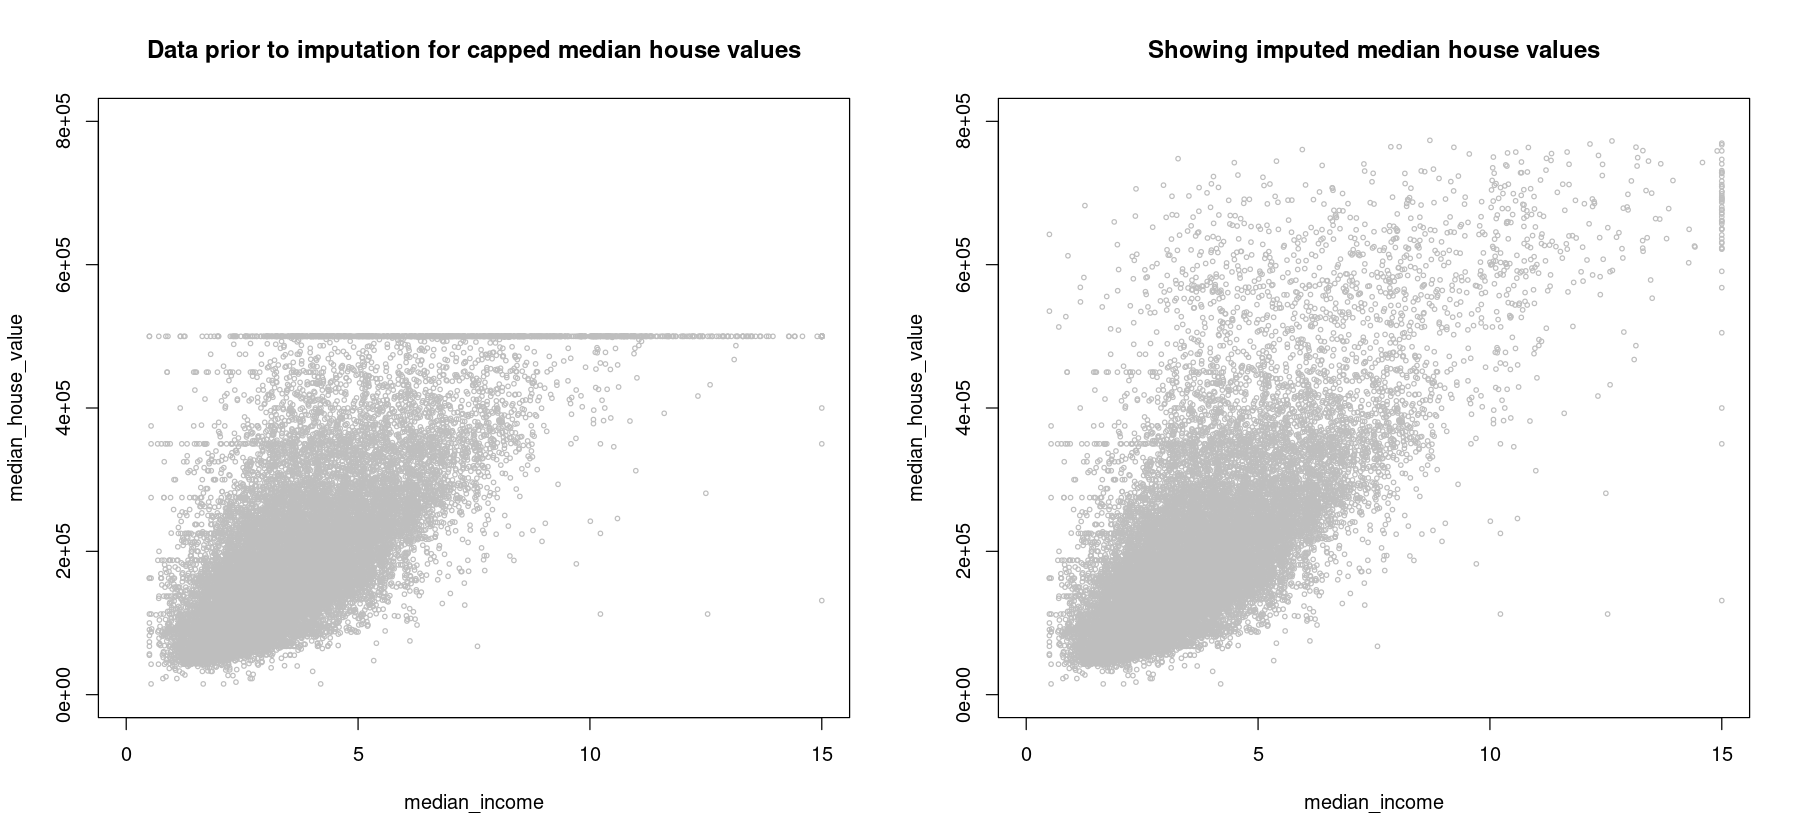

In [89]:
# Plot both before and after.

options(repr.plot.width= 15, repr.plot.height= 7)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# layout.show(n = 2)

# plot the "before" scatter
plot(dat$median_income, dat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.80e06), xlim= c(0, 15),
     main= "Data prior to imputation for capped median house values")


# plot the newly predicted values
plot(newdat$median_income, newdat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.80e06), xlim= c(0, 15),
     main= "Showing imputed median house values")


### Save to disk

In [90]:
# Save imputed values for median_house_value.

write.csv(newdat,
          file="/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v04.csv",
          row.names=TRUE)


In [104]:
dat <- newdat
rm(newdat)


## Re-assess Section 1 predictions for mean and median

In this section I run the same kind of check that I ran in Appendix A.  We can make use of some of the imputed values to extend the dataset that I used for the g02 and g03 models.  Adding a few more datapoints will improve our predictions without too heavy a dependence on the newly imputed values.

In [3]:
dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v04.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat)


[1] 20603    15

In [105]:
summary(dat$median_house_value)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15000  119600  179800  211958  264950  773490 

In [106]:
# In Section 1 above the bins went out to 330K, giving
# us 20 bins.

bins <- seq(45000, 390000, by= 15000)
bin_names <- paste(as.character(bins/1000), "K", sep="")
names(bins) <- bin_names
length(bins)


[1] 24

In [107]:
# Get means and medians for each bin, using a 240K window. 

mean_ratios <- median_ratios <- rep(NA, length(bins))
means <- medians <- rep(NA, length(bins))
rcd_count <- rep(NA, length(bins))

span <- 240000
index <- 0
for(floor in bins) {
    
    index <- index + 1
    hhvals <- as.numeric(dat[which((dat$median_house_value >= floor) &
                        (dat$median_house_value <= (floor + span))),
                  c("median_house_value")])
    counts <- as.numeric(get_rcd_counts(hhvals, c(floor, (floor+span))))
    rcd_count[index] <- sum(counts)
    
    # Compute mean.
    hhval_mean <- round(mean(hhvals), 5)
    mean_ratios[index] <- round(hhval_mean/floor, 3)
    means[index] <- hhval_mean

    # Compute median.
    hhval_median <- round(median(hhvals), 5)
    median_ratios[index] <- round(hhval_median/floor, 3)
    medians[index] <- hhval_median
}

paste0("These are the 240K shift increments for the means: ")
names(mean_ratios) <- bin_names
print(mean_ratios)


[1] "These are the 240K shift increments for the means: "

  45K   60K   75K   90K  105K  120K  135K  150K  165K  180K  195K  210K  225K 
3.529 2.774 2.342 2.062 1.887 1.755 1.642 1.557 1.506 1.458 1.423 1.382 1.350 
 240K  255K  270K  285K  300K  315K  330K  345K  360K  375K  390K 
1.332 1.310 1.289 1.279 1.265 1.247 1.241 1.244 1.254 1.255 1.255 


In [108]:
# Construct dataframe for plotting, etc.

df_ratios <- rep(NA, 6*length(mean_ratios))
dim(df_ratios) <- c(length(mean_ratios), 6)
df_ratios <- as.data.frame(df_ratios)
colnames(df_ratios) <- c("cell", "rcds","mean","median","mean_ratio","median_ratio")
df_ratios$cell <- bins
df_ratios$rcds <- rcd_count
df_ratios$mean_ratio <- mean_ratios
df_ratios$median_ratio <- median_ratios
df_ratios$mean <- means
df_ratios$median <- medians


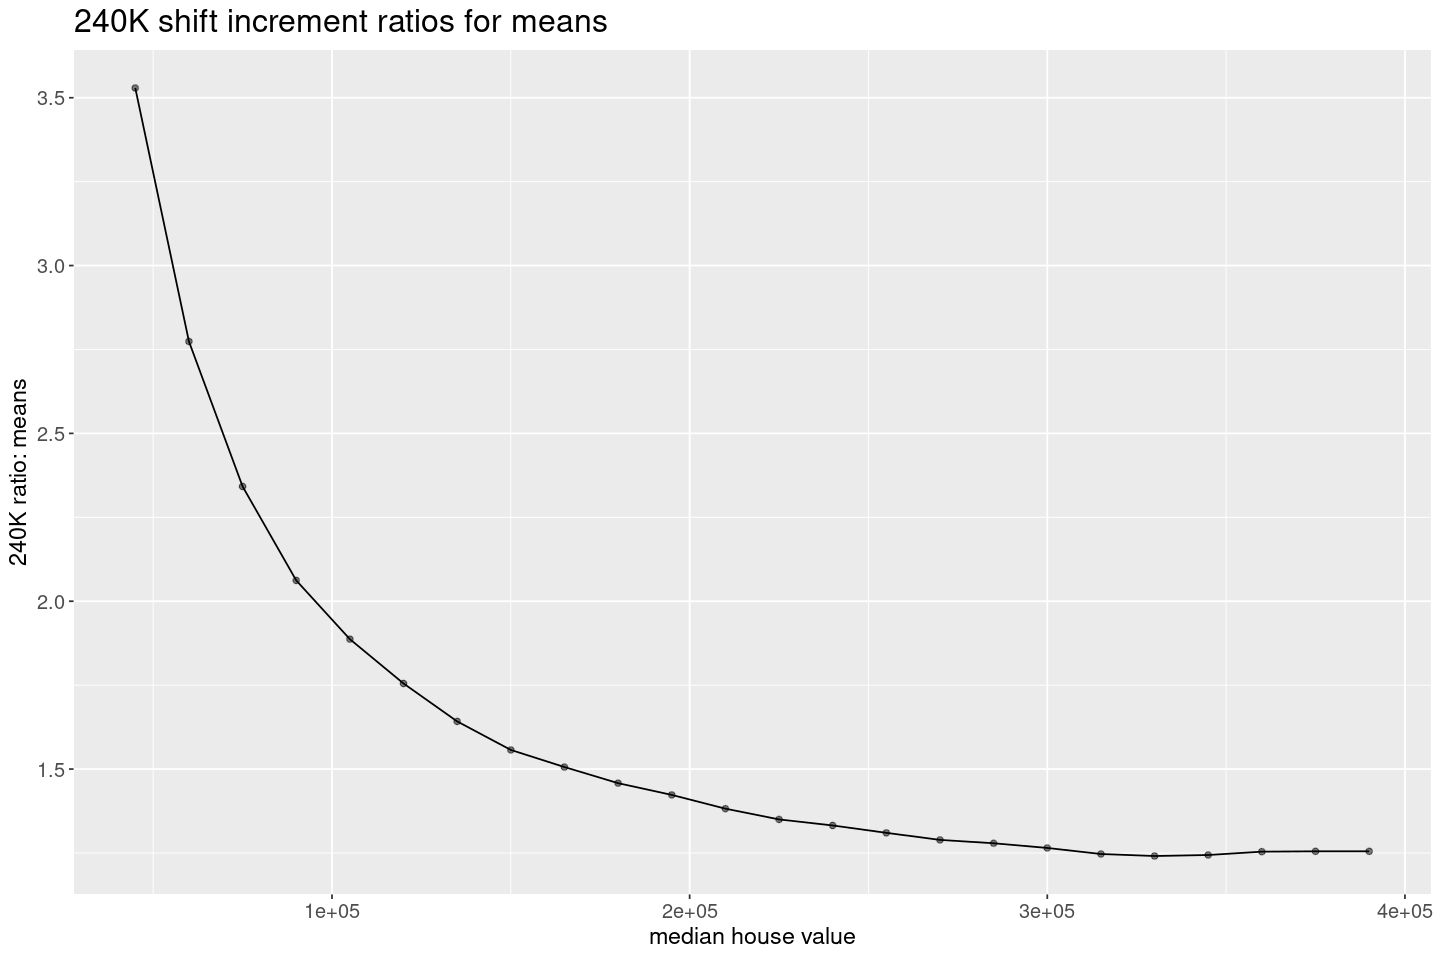

In [109]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_ratios, aes(cell, mean_ratio)) +
  geom_point(alpha= 0.5) + xlab("median house value") + 
  ylab("240K ratio: means") +
  geom_line() +
  ggtitle("240K shift increment ratios for means") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [110]:
# Model for predicting mean_ratio at 500K.

h02 <- lm(I(mean_ratio^0.10) ~ I(rcds^0.2) + I((rcds^0.2)^2) + 
          I(cell^-0.66) , 
          data= df_ratios)

ans <- summary(h02)
ans[[1]] <- ""; ans



Call:
""

Residuals:
      Min        1Q    Median        3Q       Max 
-1.15e-03 -4.69e-04  9.32e-05  4.16e-04  9.09e-04 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)
(Intercept)      1.07e+00   9.12e-03  117.40  < 2e-16
I(rcds^0.2)     -3.03e-02   3.32e-03   -9.13  1.4e-08
I((rcds^0.2)^2)  2.37e-03   3.11e-04    7.63  2.4e-07
I(cell^-0.66)    1.89e+02   2.07e+00   90.91  < 2e-16

Residual standard error: 0.00061 on 20 degrees of freedom
Multiple R-squared:     1,	Adjusted R-squared:     1 
F-statistic: 1.85e+04 on 3 and 20 DF,  p-value: <2e-16


In [111]:
ncvTest(h02)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 1.4065, Df = 1, p = 0.236

In [112]:
residualPlots(h02, plot=FALSE)


                Test stat Pr(>|Test stat|)
I(rcds^0.2)          0.03             0.98
I((rcds^0.2)^2)     -2.84             0.01
I(cell^-0.66)       -0.01             0.99
Tukey test          -0.05             0.96


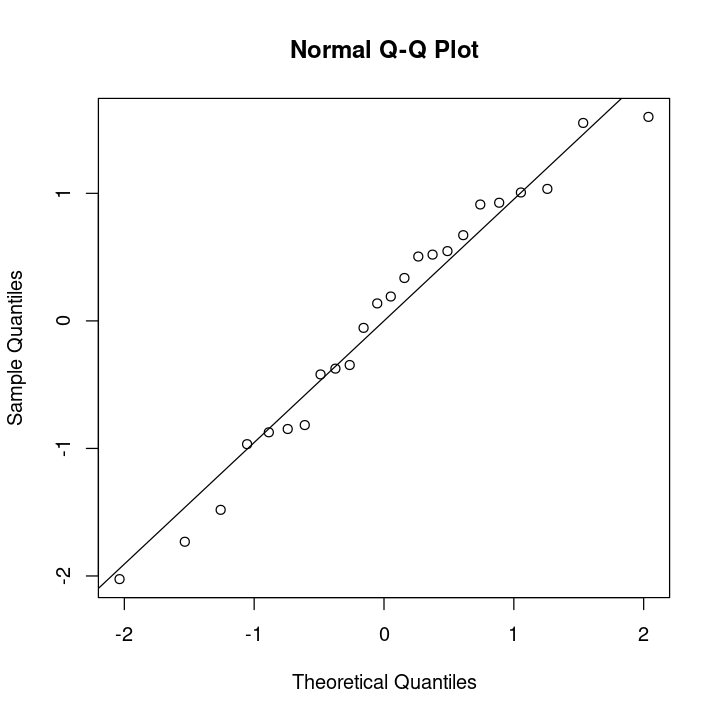

In [113]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(h02, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [114]:
newdat <- df_ratios[1, ]
newdat[1, ] <- c(500000, 990, rep(NA, 4))

ans <- predict.lm(h02, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.10); ans_transf
# 1.222

# 1.222 * 500 = 611


1 
1.2223

In [115]:
# Compute a 95% CI for this prediction.

round((ans + c(-2,2)*0.00061)^(1/0.10) * 500)
# [604, 618]


[1] 604 618

### Re-assess the Section 1 prediction for the median (model g03)

In [116]:
paste0("These are the 240K shift increments for the medians: ")
names(median_ratios) <- bin_names
print(median_ratios)


[1] "These are the 240K shift increments for the medians: "

  45K   60K   75K   90K  105K  120K  135K  150K  165K  180K  195K  210K  225K 
3.487 2.700 2.241 1.962 1.783 1.643 1.555 1.475 1.422 1.376 1.350 1.305 1.278 
 240K  255K  270K  285K  300K  315K  330K  345K  360K  375K  390K 
1.278 1.272 1.250 1.228 1.206 1.186 1.182 1.189 1.205 1.201 1.213 


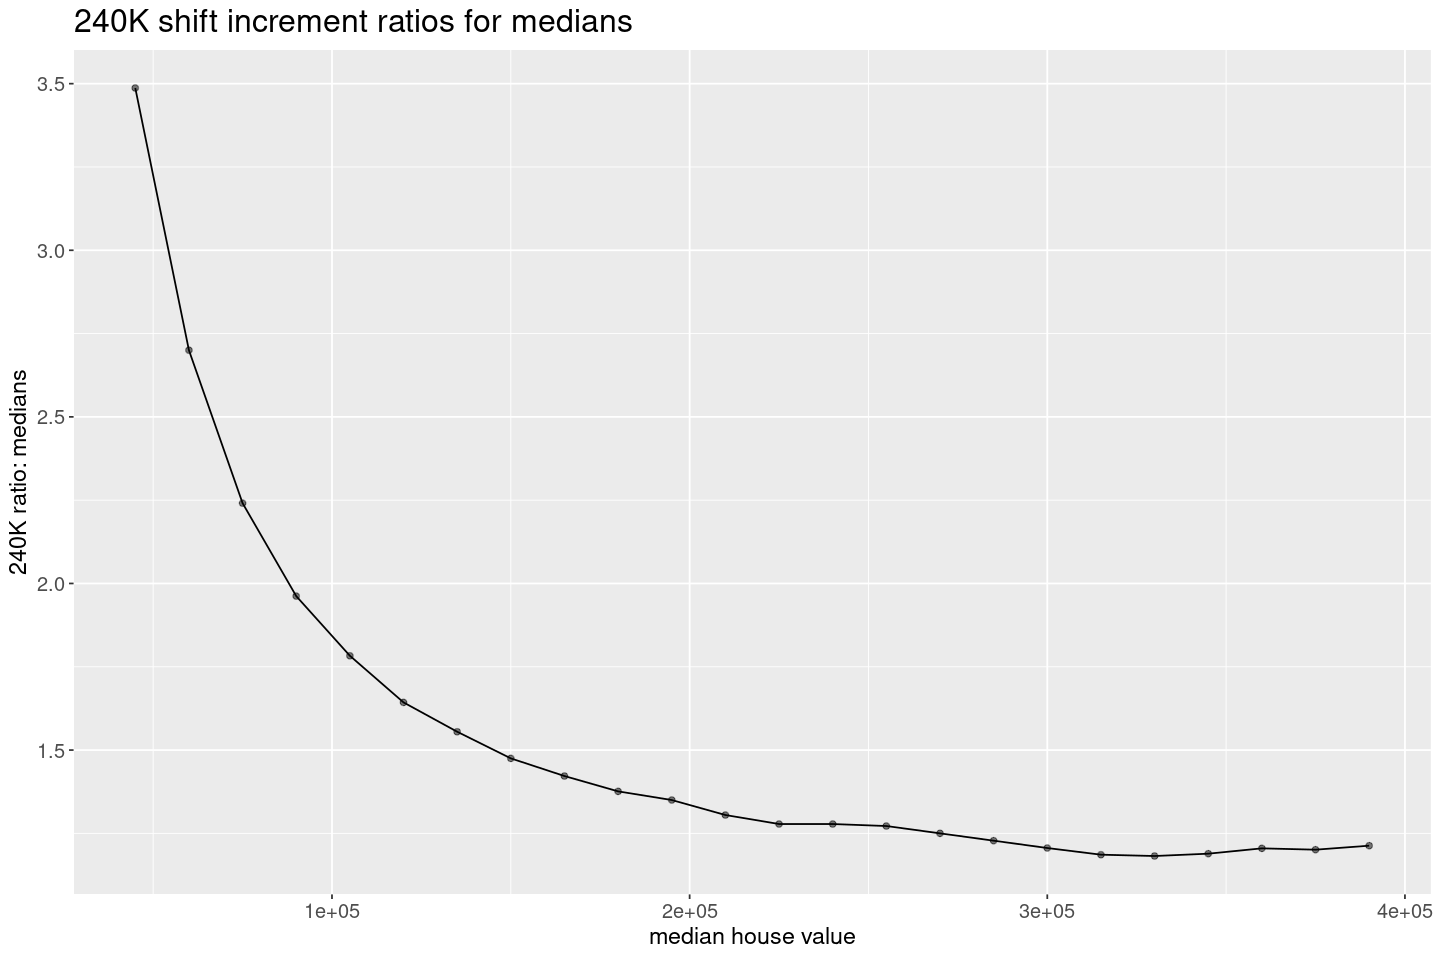

In [117]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_ratios, aes(cell, median_ratio)) +
  geom_point(alpha= 0.5) + xlab("median house value") + 
  ylab("240K ratio: medians") +
  geom_line() +
  ggtitle("240K shift increment ratios for medians") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [118]:
# Model for predicting median_ratio at 500K.

h03 <- lm(I(median_ratio^0.38) ~ I(rcds^0.33) +  
          I(cell^-0.62), 
          data= df_ratios)

ans <- summary(h03)
ans[[1]] <- ""; ans



Call:
""

Residuals:
     Min       1Q   Median       3Q      Max 
-0.00946 -0.00310  0.00116  0.00274  0.01026 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)
(Intercept)    9.39e-01   4.60e-03   204.2  < 2e-16
I(rcds^0.33)  -9.74e-03   4.34e-04   -22.4  3.7e-16
I(cell^-0.62)  6.94e+02   7.84e+00    88.6  < 2e-16

Residual standard error: 0.00466 on 21 degrees of freedom
Multiple R-squared:  0.999,	Adjusted R-squared:  0.999 
F-statistic: 1.01e+04 on 2 and 21 DF,  p-value: <2e-16


In [119]:
ncvTest(h03)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 2.0008, Df = 1, p = 0.157

In [120]:
residualPlots(h03, plot=FALSE)


              Test stat Pr(>|Test stat|)
I(rcds^0.33)       0.29             0.78
I(cell^-0.62)      1.28             0.21
Tukey test         1.13             0.26


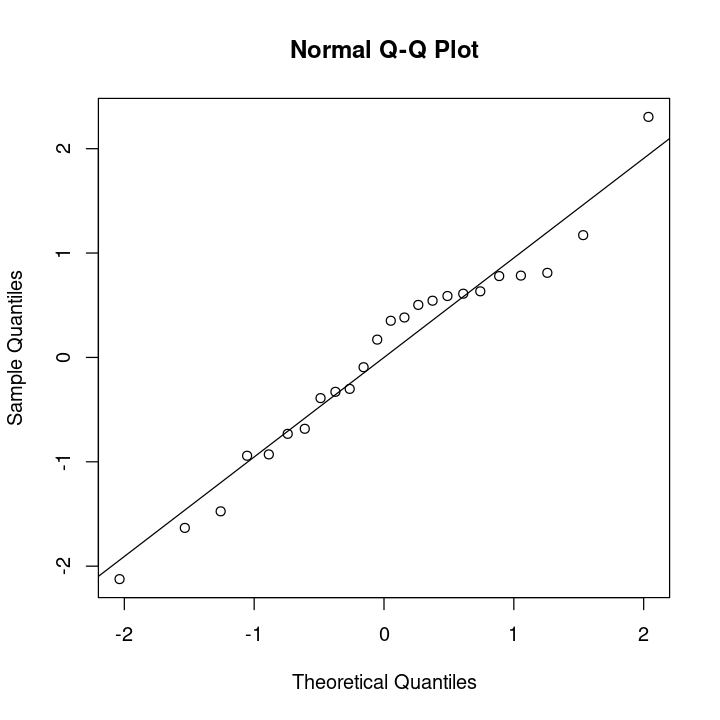

In [121]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(h03, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [122]:
# Prediction for median for [500K, 740K].

newdat <- df_ratios[1, ]
newdat[1, ] <- c(500000, 990, rep(NA, 4))

ans <- predict.lm(h03, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.38); ans_transf
# 1.130

# 1.130 * 500K = 565K.  The g03 model predicted 570K,
# with an upper 95% CI boundary of 578.


1 
1.1297

In [123]:
# Compute a 95% CI for this prediction.

round((ans + c(-2,2)*0.00466)^(1/0.38) * 500)
# [552, 578]


[1] 552 578

In [ ]:
### COMMENT:

# My predictions for the median are consistently low.
# This tells me that my approach needs some kind of
# an adjustment.  It may be that I would get better
# predictions for the median by using 10K intervals
# rather than 15K intervals.  I will leave off researching
# this question for another time.


## Re-impute values with updated prediction for the mean

In [124]:
# Re-load the data that we started with at the beginning of Section 1.

dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat)


[1] 20603    15

In [125]:
# Set the upper limit to 840K. 

cap <- 500000
response_var_power <- 0.18
inv_pwr <- 1/response_var_power

C <- cap^response_var_power
C_upper <- (1.68*cap)^response_var_power

censored <- (dat$median_house_value)^response_var_power >= C

# Create some crude starting values.
n.censored <- sum(censored)
z <- ifelse(censored, NA, (dat$median_house_value)^response_var_power)
z[censored] <- runif(n.censored, C, C_upper)


In [126]:
length(censored)
n.censored


[1] 20603

[1] 990

In [127]:
# We do not need to re-run the Gibbs sampler.

load("/home/greg/Documents/stat/Geron_ML/datasets/housing/sims_raw_hhvals.RData")


In [128]:
# Drop the first 1000 iterations.

sims_adj <- sims[1001:2000, ,]
dim(sims_adj)


[1] 1000    4 1007

In [129]:
sims_adj.bugs <- R2OpenBUGS::as.bugs.array(sims_adj)
# print(sims_adj.bugs)


In [130]:
# Extract the means and stddevs for each of the censored records.

z_means <- sims_adj.bugs$mean$z
z_sds <- sims_adj.bugs$sd$z
round(head(z_means), 2); round(head(z_sds), 2)


[1] 10.98 10.98 10.97 10.99 10.98 11.21

[1] 0.26 0.25 0.25 0.25 0.26 0.27

In [131]:
summary(z_means)
summary(z_sds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   11.0    11.0    11.0    11.1    11.1    11.5 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.111   0.252   0.255   0.255   0.263   0.282 

In [132]:
summary(round(z_means^inv_pwr))


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 598435  601765  603464  629282  644081  795604 

In [133]:
# Average estimate of the sd.

(sd_estimate <- round((11 + 0.255)^inv_pwr) - round(11^inv_pwr))
# 82,860


[1] 82860

In [ ]:
### COMMENTS:

# Based on the work above, we now expect the mean to be about
# 610K if the upper limit is around 840K.  The mean is
# currently around 640K (see next summary).


In [134]:
# Get some predictions, using rnorm.trunc03.

set.seed(1931)
z_preds <- round(rnorm.trunc03(n.censored, z_means, z_sds, lo=C, hi=C_upper), 5)
z_preds <- round(z_preds^inv_pwr)
summary(z_preds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 500761  578612  632510  639827  693094  839880 

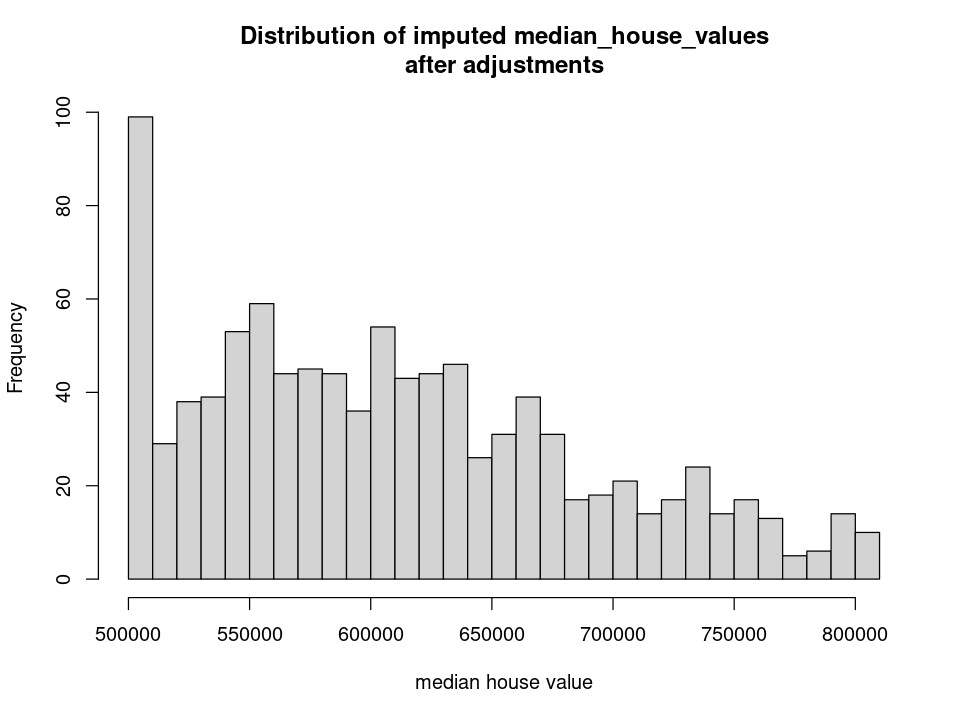

In [135]:
# Adjust the predictions so that the mean is closer to
# 610K.

z_preds_adj <- z_preds - 30000
preds_adj <- ifelse(z_preds_adj < 500000, 500000, z_preds_adj)

options(repr.plot.width= 8, repr.plot.height= 6)

hist(preds_adj, breaks=40, main="Distribution of imputed median_house_values
after adjustments",
     xlab="median house value")


In [136]:
# The mean is now about where we expect it to be.

summary(preds_adj)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 500000  548612  602510  610749  663094  809880 

In [ ]:
### COMMENTS:

# Again, we need to correct for the sharp drop in counts, 
# since this is not what we expect for the shape.


In [137]:
(z_means_bar <- mean(z_means))

z_means_adj <- z_means - (z_means_bar - 610000^response_var_power)
summary(z_means_adj)
round(mean(z_means_adj)^inv_pwr)


[1] 11.057

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   10.9    10.9    10.9    11.0    11.0    11.5 

[1] 610000

In [138]:
# Get new predictions.

set.seed(1931)
z_preds <- round(rnorm.trunc03(n.censored, z_means_adj, z_sds, lo=C, hi=C_upper), 5)
z_preds <- round(z_preds^inv_pwr)
summary(z_preds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 500541  566774  617702  626768  676412  839824 

In [139]:
# Make another correction.  Also adjust C_upper.

C_upper <- 11.5

z_means_adj <- z_means - (z_means_bar - 595000^response_var_power)

set.seed(1933)
z_preds <- round(rnorm.trunc03(n.censored, z_means_adj, z_sds, lo=C, hi=C_upper), 5)
z_preds <- round(z_preds^inv_pwr)
summary(z_preds)
# The mean is now at 610.6K.  And the median is at 599K.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 500887  557136  599224  610654  658854  781010 

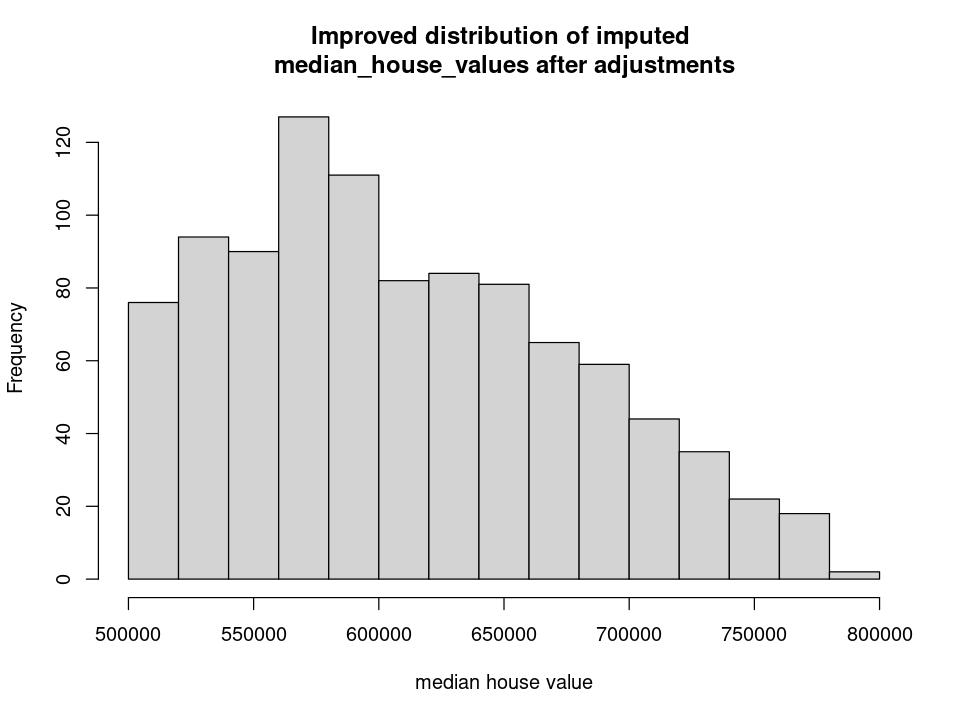

In [140]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds, breaks=20, main="Improved distribution of imputed 
median_house_values after adjustments",
     xlab="median house value")


In [ ]:
### COMMENTS:

# We should re-run model h02 to check that the 
# prediction is consistent.  I am not going to
# worry about the prediction for the median.


In [141]:
# Assign imputed values.

newdat <- dat
newdat$median_house_value[censored] <- z_preds
summary(newdat$median_house_value)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  14999  119600  179800  212225  264950  781010 

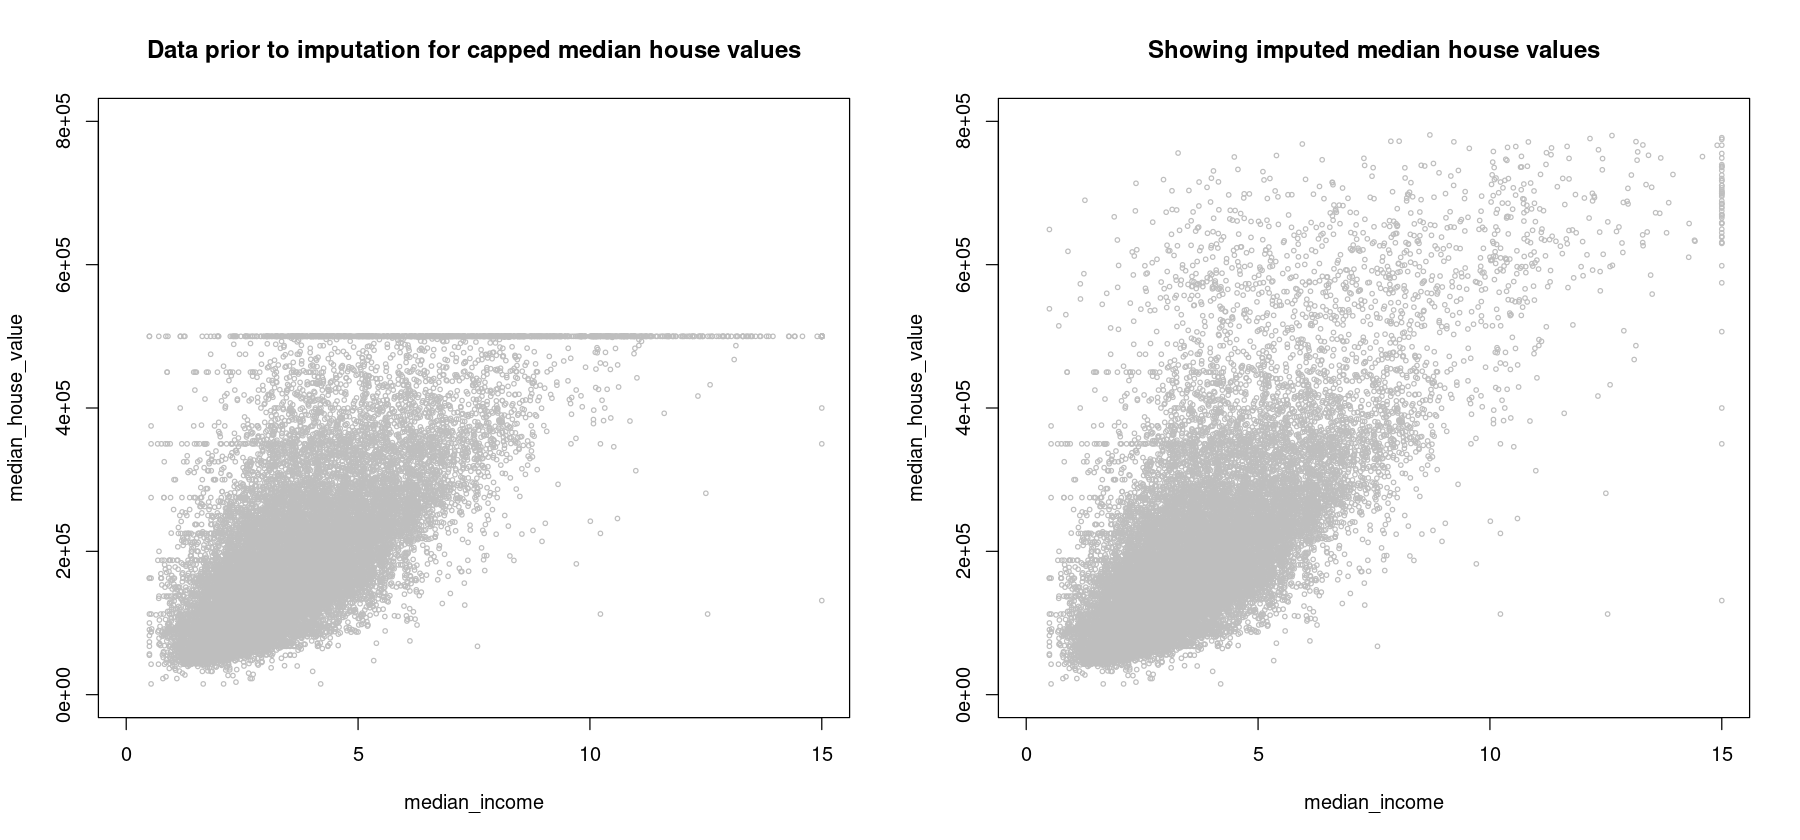

In [161]:
# Plot both before and after.

options(repr.plot.width= 15, repr.plot.height= 7)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# layout.show(n = 2)

# plot the "before" scatter
plot(dat$median_income, dat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.80e06), xlim= c(0, 15),
     main= "Data prior to imputation for capped median house values")


# plot the newly predicted values
plot(newdat$median_income, newdat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.80e06), xlim= c(0, 15),
     main= "Showing imputed median house values")


### Save to disk

In [162]:
# Save imputed values for median_house_value.

write.csv(newdat,
          file="/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v04.csv",
          row.names=TRUE)


In [142]:
dat <- newdat
rm(newdat)


## Take 2: Re-assess prediction for mean

In [143]:
bins <- seq(45000, 390000, by= 15000)
bin_names <- paste(as.character(bins/1000), "K", sep="")
names(bins) <- bin_names
length(bins)


[1] 24

In [144]:
# Get means and medians for each bin, using a 240K window. 

mean_ratios <- median_ratios <- rep(NA, length(bins))
means <- medians <- rep(NA, length(bins))
rcd_count <- rep(NA, length(bins))

span <- 240000
index <- 0
for(floor in bins) {
    
    index <- index + 1
    hhvals <- as.numeric(dat[which((dat$median_house_value >= floor) &
                        (dat$median_house_value <= (floor + span))),
                  c("median_house_value")])
    counts <- as.numeric(get_rcd_counts(hhvals, c(floor, (floor+span))))
    rcd_count[index] <- sum(counts)
    
    # Compute mean.
    hhval_mean <- round(mean(hhvals), 5)
    mean_ratios[index] <- round(hhval_mean/floor, 3)
    means[index] <- hhval_mean

    # Compute median.
    hhval_median <- round(median(hhvals), 5)
    median_ratios[index] <- round(hhval_median/floor, 3)
    medians[index] <- hhval_median
}

paste0("These are the 240K shift increments for the means: ")
names(mean_ratios) <- bin_names
print(mean_ratios)


[1] "These are the 240K shift increments for the means: "

  45K   60K   75K   90K  105K  120K  135K  150K  165K  180K  195K  210K  225K 
3.529 2.774 2.342 2.062 1.887 1.755 1.642 1.557 1.506 1.458 1.423 1.382 1.350 
 240K  255K  270K  285K  300K  315K  330K  345K  360K  375K  390K 
1.332 1.310 1.289 1.277 1.262 1.244 1.236 1.240 1.252 1.252 1.252 


In [145]:
# Construct dataframe for plotting, etc.

df_ratios <- rep(NA, 6*length(mean_ratios))
dim(df_ratios) <- c(length(mean_ratios), 6)
df_ratios <- as.data.frame(df_ratios)
colnames(df_ratios) <- c("cell", "rcds","mean","median","mean_ratio","median_ratio")
df_ratios$cell <- bins
df_ratios$rcds <- rcd_count
df_ratios$mean_ratio <- mean_ratios
df_ratios$median_ratio <- median_ratios
df_ratios$mean <- means
df_ratios$median <- medians


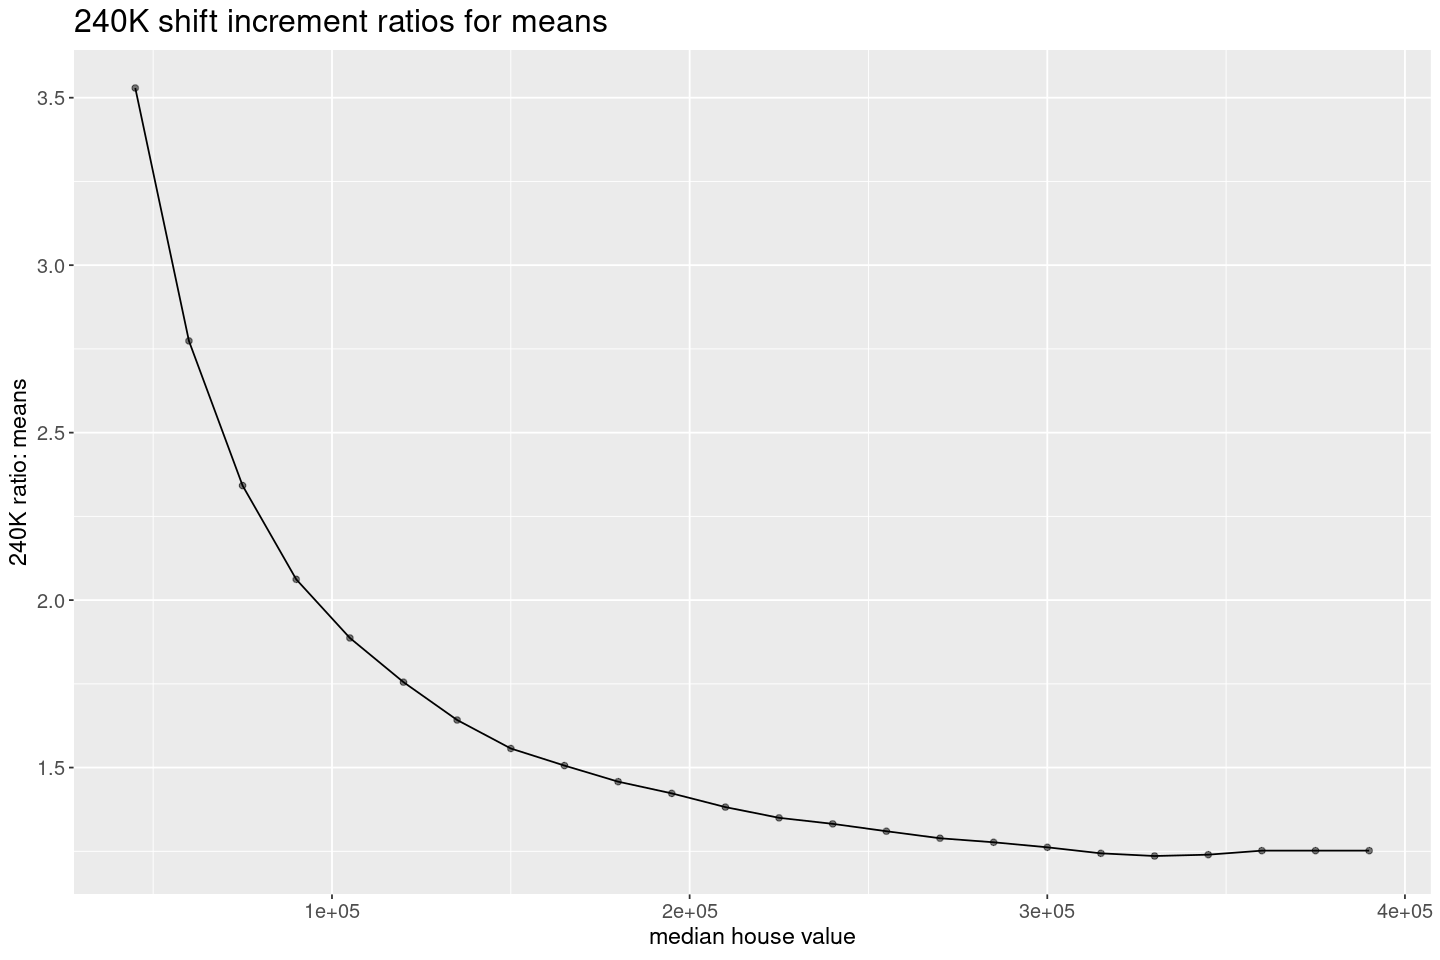

In [146]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_ratios, aes(cell, mean_ratio)) +
  geom_point(alpha= 0.5) + xlab("median house value") + 
  ylab("240K ratio: means") +
  geom_line() +
  ggtitle("240K shift increment ratios for means") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [147]:
# Model for predicting mean_ratio at 500K.

h02 <- lm(I(mean_ratio^0.08) ~ I(rcds^0.2) + I((rcds^0.2)^2) + 
          I(cell^-0.67) , 
          data= df_ratios)

ans <- summary(h02)
ans[[1]] <- ""; ans



Call:
""

Residuals:
      Min        1Q    Median        3Q       Max 
-9.58e-04 -3.62e-04  4.01e-05  3.63e-04  7.16e-04 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)
(Intercept)      1.06e+00   7.71e-03  136.83  < 2e-16
I(rcds^0.2)     -2.36e-02   2.81e-03   -8.40  5.4e-08
I((rcds^0.2)^2)  1.89e-03   2.64e-04    7.17  6.1e-07
I(cell^-0.67)    1.63e+02   1.96e+00   83.19  < 2e-16

Residual standard error: 0.000524 on 20 degrees of freedom
Multiple R-squared:     1,	Adjusted R-squared:     1 
F-statistic: 1.57e+04 on 3 and 20 DF,  p-value: <2e-16


In [148]:
ncvTest(h02)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 1.3824, Df = 1, p = 0.24

In [149]:
residualPlots(h02, plot=FALSE)


                Test stat Pr(>|Test stat|)
I(rcds^0.2)         -0.59            0.562
I((rcds^0.2)^2)     -2.44            0.025
I(cell^-0.67)       -0.28            0.779
Tukey test          -0.33            0.739


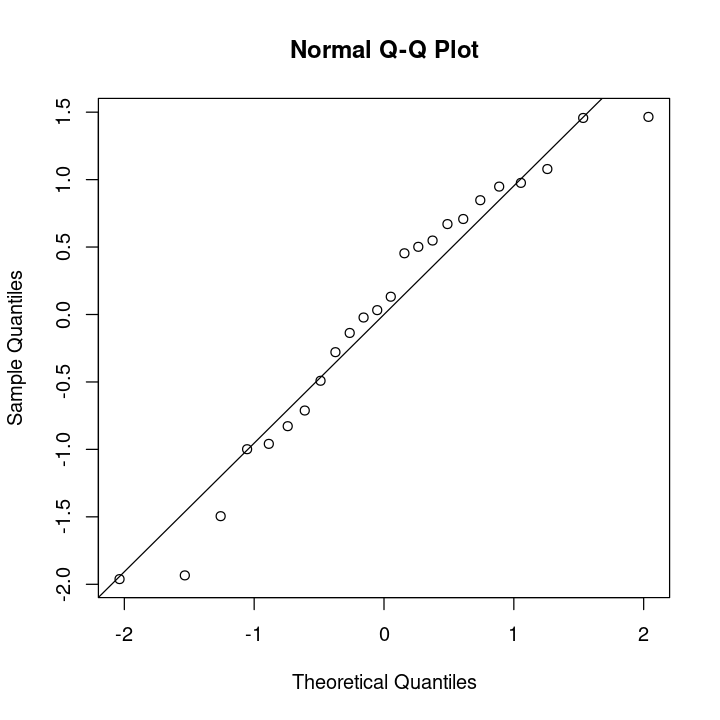

In [150]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(h02, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [151]:
# Prediction for mean is for [500K, 740K].

newdat <- df_ratios[1, ]
newdat[1, ] <- c(500000, 990, rep(NA, 4))

ans <- predict.lm(h02, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.08); ans_transf
# 1.217

# 1.217 * 500K = 608.5K.


1 
1.2167

In [152]:
# Compute a 95% CI for this prediction.

round((ans + c(-2,2)*0.000524)^(1/0.08) * 500)
# [601, 616]


[1] 601 616

In [173]:
nrow(dat[which(dat$median_house_value > 740000),])


[1] 42

In [ ]:
### COMMENTS:

# The prediction of 608.5K is for the range [500K, 740K],
# but our predictions go out to 781K.  We have 42 of the
# 990 records (4.2%) with a value > 740K.  This might be 
# enough to pull the mean out to 610.6K.

# Thus, I think we can say that we now have a good set of
# imputed values for the records with a censored median
# house value.


## Final Comments for Appendix B

An additional check to see that the imputed values are consistent with the data and with the Gibbs sampler output is made in Section 2 of Part01.

My concern about predicting both a mean and a median of the distribution of actual, unobserved values in the range above the cap might be overkill.  For in the above process (and this was also true in Appendix A) when I make adjustments to z_preds to control where the mean will be, I have no control over where the median will be.  Changes would have to be made to the rnorm.trunc03 function in order to control both the location of the mean and the median.  Such changes are unwarranted, however, unless we can be very confident about where the median actually lies.  In this appendix, I was not able to establish that to the same degree that I was for the mean.